# Analyse images to determine asymmetry of comets ##

Look at images, find good comets using three thresholds and determine their asymmetry.

## Some useful routines

Convert RGBA images to RGB and RGB to greyscale. Ceiling division. Analysis routines...

Note that must set negative = 1 in call to rgb2grey in processImage for MC data, negative = 0 for real images.

In [1]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import numpy as np
#
def rgba2rgb(rgba, background = (255, 255, 255)):
    '''
    Function to convert RGBA images into RGB format. Input RGBA image (and background); output RGB image.
    '''
    rows, cols, chans = rgba.shape
    #
    debug = False
    #
    if debug:
        print("------------------------------------------------------------------------------------")
        print("Running rgba2rgb")
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
            return rgba
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 4, 'RGBA image must have 4 channels.'
    #
    rgb = np.zeros((rows, cols, 3), dtype = 'float32')
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    #
    a = np.asarray(a, dtype='float32')/255.0
    #
    R, G, B = background
    #
    rgb[:, :, 0] = r*a + (1.0 - a)*R
    rgb[:, :, 1] = g*a + (1.0 - a)*G
    rgb[:, :, 2] = b*a + (1.0 - a)*B
    #
    return np.asarray(rgb, dtype = np.uint8)
#
#
#
def rgb2grey(rgb, negative = 0, withHists = False):
    '''
    Convert RGB image to greyscale. Input RGB (and flag indicating negative required), output greyscale image.
    '''
    rows, cols, chans = rgb.shape
    #
    debugHere = False
    #
    if debugHere:
        print("------------------------------------------------------------------------------------")
        print("Running rgb2grey")
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    grey = np.zeros((rows, cols), dtype = 'float32')
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #
    grey[:, :] = (0.2125*(r*negative + (negative - 1.0)*r) + 
                  0.7154*(g*negative + (negative - 1.0)*g) + 
                  0.0721*(b*negative + (negative - 1.0)*b))
    if withHists:
        print(" ")
        print("Max intensities red",np.amax(r),"blue",np.amax(b),"green",np.amax(g))
        print(" ")
        nBins = int(256/8)
        nBins = 256
        plt.figure(figsize = (10, 9))
        plt.subplot(4, 1, 1)
        plt.hist(np.ravel(r), bins = nBins, color = 'r')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 2)
        plt.hist(np.ravel(g), bins = nBins, color = 'g')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 3)
        plt.hist(np.ravel(b), bins = nBins, color = 'b')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 4)
        plt.hist(np.ravel(grey), bins = nBins, color = 'k')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.tight_layout()
        plt.show()
    #
    return np.asarray(grey, dtype = np.uint8)
#
#
#
def ceilDiv(a, b):
    '''
    Return a//b rounded up.
    '''
    ceiling = -(-a//b)
    return ceiling
#
#
#
def processImage(imgRaw, hotCut, withHists):
    #
    import sys
    import numpy as np
    import scipy.ndimage as ndimage
    import matplotlib.pyplot as plt
    %matplotlib inline
    # 
    # Number of rows and columns. Depth is 3 for RGB, 4 for RGBA image. A is opacity (alpha)
    nRows = imgRaw.shape[0] 
    nCols = imgRaw.shape[1]
    nDepth = imgRaw.shape[2]
    #
    nThresh = len(thresh)
    img = np.zeros((nRows, nCols))
    imgThr = np.zeros((nRows, nCols, nThresh))
    #
    # Determine image format and process accordingly
    if nDepth == 4:
        imgRGB = rgba2rgb(imgRaw)
        imgGrey = rgb2grey(imgRGB, 0, withHists)
    elif nDepth == 3:
        imgRGB = imgRaw
        imgGrey = rgb2grey(imgRGB, 1, withHists)
    elif nDepth == 1:
        imgRGB = imgRaw
        imgGrey = imgRaw
    else:
        print(" ")
        print("Unexpected image depth",nDepth)
        sys.stop()
    #
    # Remove "hot" pixels
    hotPixels = imgGrey > hotCut
    imgGrey[hotPixels] = 0
    #
    # Rescale 
    imgGrey = np.asarray(255/hotCut*imgGrey, dtype = np.uint8)
    #
    if withHists:
        print(" ")
        print("Maximum pixel value before removing hot pixels",np.amax(imgGrey))
        print("Minimum pixel value ",np.amin(imgGrey))
        print("Type of raw image file is",imgRaw.dtype)
        print("Type of greyscale image file is",imgGrey.dtype)
        print("Number of rows",nRows,"of columns",nCols,"of pixels",nRows*nCols,"and depth",nDepth)
        print("Hot pixel cut",hotCut)
        print("Number of hot pixels",np.sum(hotPixels))
        print("Maximum pixel value after removing hot pixels",np.amax(imgGrey))
        print("Minimum pixel value ",np.amin(imgGrey))
    #
    return imgGrey, nRows, nCols
#
#
#
def findWheels(imgGrey, threshold):
    #
    if not hasattr(findWheels, "firstCall"):
        findWheels.firstCall = True
        print("------------------------------------------------------------------------------------")
        print("Running findWheels")
    if debug:
        findWheels.firstCall = True
        print("------------------------------------------------------------------------------------")
        print("Running findWheels")
    #
    # Create image with cluster threshold and run watershed algorithm
    clusImg = imgGrey > threshold
    if debug:
        plt.figure(figsize = (pltX, pltY))
        plt.imshow(clusImg);
    colDotsClus = ndimage.watershed_ift(clusImg.astype(np.uint8), markers)
    #
    # Remove "isolated" markers (i.e. markers in regions where no cluster found)
    colDotsClus[rMark, cMark] = colDotsClus[rMark + 1, cMark]
    #
    # Find the value of the marker of the last identified regions
    mMaxClus = np.amax(colDotsClus)
    #
    # Positions of marker values
    boolClus = colDotsClus >= mStart
    nFoundClus = len(np.unique(colDotsClus[boolClus]))
    rMarkerClus = np.zeros(nFoundClus)
    rMarkerClus = np.unique(colDotsClus[boolClus])
    #
    # Select the clusters, first pass (determine accepted number). Must exclude tiny clusters (noise) and any 
    # really large clusters (background regions in image).
    nClus = 0
    cMarkerClus = np.zeros(nFoundClus)
    maxInDotClus = 0
    for nR in range(0, nFoundClus):
        boolClus = colDotsClus == rMarkerClus[nR]
        nHereCl = np.sum(boolClus)
        if nHereCl < minClusPixels or nHereCl > maxClusPixels:
            continue
        maxInDotClus = max(maxInDotClus, nHereCl)
        cMarkerClus[nClus] = rMarkerClus[nR]
        nClus += 1
    #
    # Information on clusters
    nInCluster = np.zeros(nClus).astype(int)
    iClusSum = np.zeros(nClus)
    #
    # Information on pixels in clusters
    lClus = np.sum(clusImg)
    #
    # Safe size of arrays would be number of pixels in image. Try to reduce size by using number of pixels in clusters
    # The factor lFact can be used to expand array sizes
    lFact = 4
    indexCl = np.zeros(lFact*lClus)
    cPixelsCl = np.zeros(lFact*lClus).astype(int)
    rPixelsCl = np.zeros(lFact*lClus).astype(int)
    iPixelsCl = np.zeros(lFact*lClus)
    #
    # Temporary information 
    cPixelsHere = np.zeros(lClus).astype(int)
    rPixelsHere = np.zeros(lClus).astype(int)
    iPixelsHere = np.zeros(lClus)
    #
    # Find pixels in clusters, determine positions and plot 
    if findWheels.firstCall:
        fig = plt.figure(figsize = (pltX, pltY))
        ax = fig.add_subplot(1, 1, 1)
        plt.title("Clusters with threshold " + str(threshold), fontsize = 12)
        plt.xlabel('x pixel', fontsize = 12)
        plt.ylabel('y pixel', fontsize = 12)
        #
        # Figure control
        xOffMax = 2
        yOffMax = 2
        mSize = 0.001
        nCol = 0
    #
    nLastCl = 0
    #
    for nC in range(0, nClus):
        #
        # Clusters
        boolClus = colDotsClus == cMarkerClus[nC]
        nHereCl = np.sum(boolClus).astype(int)
        #
        nInCluster[nC] = nHereCl
        #
        # Indices of x and y pixels
        rPixelsHere, cPixelsHere = np.where(boolClus)
        #
        # Intensities in pixels
        iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
        iClusSum[nC] = np.sum(iPixelsHere)
        #
        indexCl[nLastCl:nLastCl + nHereCl] = nC*np.ones(nHereCl)
        cPixelsCl[nLastCl:nLastCl + nHereCl] = cPixelsHere[:]
        rPixelsCl[nLastCl:nLastCl + nHereCl] = rPixelsHere[:]
        iPixelsCl[nLastCl:nLastCl + nHereCl] = iPixelsHere[:]
        #
        if findWheels.firstCall:
            plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
            rLab = np.amax(rPixelsHere[0:nHereCl]) + yOffMax
            cLab = np.amax(cPixelsHere[0:nHereCl]) + xOffMax
            plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
            nCol = nCol + 1
            if nCol > nColTab - 1:
                 nCol = 0
        #
        nLastCl = nLastCl + nHereCl
        #
    #
    if findWheels.firstCall:
        plt.xlim(-0.05*nCols, 1.05*nCols)
        plt.ylim(-0.05*nRows, 1.05*nRows)
        plt.grid(color = 'g')
        print(" ")
        plt.show()
        #
        findWheels.firstCall = False
    #
    return nInCluster, rPixelsCl, cPixelsCl, iPixelsCl
#
#
#
def edgeFinderIn(picture, edgeWidth, useDiag = True):
    '''
    Return array containing pixels in edges (of width edgeWidth) of input (thresholded) image.
    The edges are inside the original image. The flag useDiag ensures "corner" pixels are selected.
    '''
    #
    shiftR = edgeWidth
    shiftC = edgeWidth
    nRows, nCols = picture.shape
    edges = np.full((nRows, nCols), False)
    imgShift = np.full((nRows, nCols), False)
    #
    # Right edge
    imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
    imgShift[0:nRows, nCols - shiftC:nCols] = False
    edges = np.logical_and(picture, np.logical_not(imgShift))
    #
    # Left edge 
    imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
    imgShift[0:nRows, 0:shiftC] = False
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    # Lower edge 
    imgShift[shiftR:nRows, 0:nCols] = picture[0:nRows - shiftR, 0:nCols]
    imgShift[0:shiftR, 0:nCols] = False    
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    # Upper edge 
    imgShift[0:nRows - shiftR, 0:nCols] = picture[shiftR:nRows, 0:nCols]    
    imgShift[nRows - shiftR:nRows, 0:nCols] = False
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    if useDiag:
        #
        # Left upper edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Left lower edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Right upper edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Right lower edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    return edges
#
#
#
def expander(picture, edgeWidth, useDiag = True):
    '''
    Return array containing thresholded regions expanded by band of width edgeWidth. The flag useDiag ensures
    "corner" pixels are included correctly.
    '''
    #
    shiftR = 1
    shiftC = 1
    nRows, nCols = picture.shape
    edges = np.full((nRows, nCols), False)
    edgeSum = np.full((nRows, nCols), False)
    imgShift = np.full((nRows, nCols), False)
    #
    for  nE in range(0, edgeWidth):
        #
        # Left edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        edges = np.logical_and(np.logical_not(picture), imgShift)
        #
        # Right edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        # Upper edge 
        imgShift[shiftR:nRows, 0:nCols] = picture[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        # Lower edge 
        imgShift[0:nRows - shiftR, 0:nCols] = picture[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        if useDiag:
            #
            # Left upper edge
            imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
            imgShift[0:nRows, nCols - shiftC:nCols] = False
            imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
            imgShift[0:shiftR, 0:nCols] = False    
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Left lower edge
            imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
            imgShift[0:nRows, nCols - shiftC:nCols] = False
            imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
            imgShift[nRows - shiftR:nRows, 0:nCols] = False
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Right upper edge 
            imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
            imgShift[0:nRows, 0:shiftC] = False
            imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
            imgShift[0:shiftR, 0:nCols] = False    
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Right lower edge 
            imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
            imgShift[0:nRows, 0:shiftC] = False
            imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
            imgShift[nRows - shiftR:nRows, 0:nCols] = False
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        picture = np.logical_or(picture, edges)
        edgeSum = np.logical_or(edges, edgeSum)
    #
    return picture, edgeSum
#
#
#
def clusExpand(nInCluster, rPixelsCl, cPixelsCl, widthEx):
    #
    debugHere = False
    #
    if not hasattr(clusExpand, "firstCall"):
        clusExpand.firstCall = True
        print("------------------------------------------------------------------------------------")
        print("Running clusExpand")
    if debug:
        clusExpand.firstCall = True
        print("------------------------------------------------------------------------------------")
        print("Running clusExpand")
    #
    nClus = len(nInCluster)
    #
    # Temporary information 
    lClus = np.amax(nInCluster)
    lFact = 1
    cPixelsHere = np.zeros(lFact*lClus).astype(int)
    rPixelsHere = np.zeros(lFact*lClus).astype(int)
    thisPic = np.zeros((nRows, nCols))
    thisPicEx = np.zeros((nRows, nCols))
    thisEdge = np.zeros((nRows, nCols))
    #
    # Information on expanded cluster
    nInClusEx = np.zeros(nClus).astype(int)
    iClusExSum = np.zeros(nClus)
    #
    # Information on pixels in expanded cluster
    lFact = 30
    indexClEx = np.zeros(lFact*lClus)
    cPixelsClEx = np.zeros(lFact*lClus).astype(int)
    rPixelsClEx = np.zeros(lFact*lClus).astype(int)
    iPixelsClEx = np.zeros(lFact*lClus)
    #
    # Information on edge
    nInEdge = np.zeros(nClus).astype(int)
    iEdgeSum = np.zeros(nClus)
    #
    # Information on pixels in expanded edge
    lFact = 30
    indexEdge = np.zeros(lFact*lClus)
    cPixelsEdge = np.zeros(lFact*lClus).astype(int)
    rPixelsEdge = np.zeros(lFact*lClus).astype(int)
    iPixelsEdge = np.zeros(lFact*lClus)
    #
    # Pictures before and after expanding and edges (all clusters)
    clusPic = np.zeros((nRows, nCols))
    clusPicEx = np.zeros((nRows, nCols))
    edgePic = np.zeros((nRows, nCols))
    #
    if clusExpand.firstCall:
        fig = plt.figure(figsize = (pltX, pltY))
        ax = fig.add_subplot(1, 1, 1)
        plt.title("Expanded clusters", fontsize = 12)
        plt.xlabel('x pixel', fontsize = 12)
        plt.ylabel('y pixel', fontsize = 12)
        #
        # Figure control
        xOffMax = 2
        yOffMax = 2
        xOffMin = 30
        yOffMin = 30
        mSize = 0.001
        nCol = 0
    #
    nLastCl = 0
    nLastClEx = 0
    nLastEdge = 0
    for nC in range(0, nClus):
        #
        # Clusters
        nHereCl = nInCluster[nC]
        #
        # Indices of x and y pixels
        thisPic.fill(0) 
        thisPic[rPixelsCl[nLastCl:nLastCl + nHereCl], cPixelsCl[nLastCl:nLastCl + nHereCl]] = 1
        clusPic += thisPic
        #
        nLastCl = nLastCl + nHereCl
        #
        # Expand cluster
        thisExp, thisEdge = expander(thisPic, widthEx, useDiag)
        nHereClEx = np.sum(thisExp).astype(int)
        nInClusEx[nC] = nHereClEx
        #
        # Indices of x and y pixels expanded cluster
        rPixelsHereEx, cPixelsHereEx = np.where(thisExp)
        thisPicEx.fill(0)
        thisPicEx[rPixelsHereEx, cPixelsHereEx] = 1
        clusPicEx += thisPicEx
        #
        # Intensities in pixels expanded cluster
        iPixelsHereEx = imgGrey[rPixelsHereEx, cPixelsHereEx]
        iClusExSum[nC] = np.sum(iPixelsHereEx)
        #
        indexClEx[nLastClEx:nLastClEx + nHereClEx] = nC*np.ones(nHereClEx)
        cPixelsClEx[nLastClEx:nLastClEx + nHereClEx] = cPixelsHereEx[:]
        rPixelsClEx[nLastClEx:nLastClEx + nHereClEx] = rPixelsHereEx[:]
        iPixelsClEx[nLastClEx:nLastClEx + nHereClEx] = iPixelsHereEx[:]
        #
        if clusExpand.firstCall:
            plt.scatter(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx], rPixelsClEx[nLastClEx:nLastClEx + nHereClEx], 
                        s = mSize, c = colorTab[nCol], marker = 'o')
            rLab = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + yOffMax
            cLab = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + xOffMax
            plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
            nCol = nCol + 1
            if nCol > nColTab - 1:
                 nCol = 0            
        #
        nLastClEx = nLastClEx + nHereClEx
        #
        # Expanded edges
        nHereEdge = np.sum(thisEdge).astype(int)
        nInEdge[nC] = nHereEdge
        #
        # Indices of x and y pixels edge
        rPixelsHereEdge, cPixelsHereEdge = np.where(thisEdge)
        thisEdge.fill(0)
        thisEdge[rPixelsHereEdge, cPixelsHereEdge] = 1
        edgePic += thisEdge
        #
        # Intensities in pixels edge
        iPixelsHereEdge = imgGrey[rPixelsHereEdge, cPixelsHereEdge]
        iEdgeSum[nC] = np.sum(iPixelsHereEdge)
        #
        indexEdge[nLastEdge:nLastEdge + nHereEdge] = nC*np.ones(nHereEdge)
        cPixelsEdge[nLastEdge:nLastEdge + nHereEdge] = cPixelsHereEdge[:]
        rPixelsEdge[nLastEdge:nLastEdge + nHereEdge] = rPixelsHereEdge[:]
        iPixelsEdge[nLastEdge:nLastEdge + nHereEdge] = iPixelsHereEdge[:]
        nLastEdge = nLastEdge + nHereEdge
        #
    #
    if clusExpand.firstCall:
        plt.xlim(-0.05*nCols, 1.05*nCols)
        plt.ylim(-0.05*nRows, 1.05*nRows)
        plt.grid(color = 'g')
        print(" ")
        plt.show()
        #
        clusExpand.firstCall = False
    #
    if debugHere:
        print(" ")
        plt.figure(figsize = (pltX, pltY))
        plt.imshow(clusPic);
        plt.show()
        print(" ")
        plt.figure(figsize = (pltX, pltY))
        plt.imshow(clusPicEx);
        plt.show()
        print(" ")
        plt.figure(figsize = (pltX, pltY))
        plt.imshow(edgePic);
        plt.show()
    #
    return nInClusEx, rPixelsClEx, cPixelsClEx, iPixelsClEx, nInEdge, rPixelsEdge, cPixelsEdge, iPixelsEdge
#
#
#
def findRims(nInClus, rPixelsCl, cPixelsCl):
    #
    if not hasattr(findRims, "firstCall"):
        findRims.firstCall = True
        print("------------------------------------------------------------------------------------")
        print("Running findRims")
    if debug:
        findRims.firstCall = True
        print("------------------------------------------------------------------------------------")
        print("Running findRims")
    #
    useDiag = True
    #
    nClus = len(nInClus)
    lClus = np.amax(nInClus).astype(int)
    #
    # Information on cluster edge
    nInClusEd = np.zeros(nClus).astype(int)
    iClusEdSum = np.zeros(nClus)
    #
    # Information on pixels in cluster edge
    lFact = 3
    indexClEd = np.zeros(lFact*lClus)
    cPixelsClEd = np.zeros(lFact*lClus)
    rPixelsClEd = np.zeros(lFact*lClus)
    iPixelsClEd = np.zeros(lFact*lClus)
    #
    # Pictures for display/edge finding
    thisPic = np.zeros((nRows, nCols))
    thisEdge = np.zeros((nRows, nCols))
    thisEdgePic = np.zeros((nRows, nCols))
    #
    # Edge width required
    width = 1
    #
    if findRims.firstCall:
        fig = plt.figure(figsize = (pltX, pltY))
        ax = fig.add_subplot(1, 1, 1)
        plt.title("Clusters and their edges", fontsize = 12)
        plt.xlabel('x pixel', fontsize = 12)
        plt.ylabel('y pixel', fontsize = 12)
        #
        # Figure control
        xOffMax = 2
        yOffMax = 2
        xOffMin = 30
        yOffMin = 30
        nCol = 0
        mSize = 0.001
    #
    nLastCl = 0
    nLastClEd = 0
    for nC in range(0, nClus):
        #
        # Clusters
        nHereCl = nInClus[nC]
        #
        # Indices of x and y pixels
        thisPic.fill(0)
        thisPic[rPixelsCl[nLastCl:nLastCl + nHereCl], cPixelsCl[nLastCl:nLastCl + nHereCl]] = 1
        #
        if findRims.firstCall:
            plt.scatter(cPixelsCl[nLastCl:nLastCl + nHereCl], rPixelsCl[nLastCl:nLastCl + nHereCl],
                        s = mSize, c = colorTab[nCol], marker = 'o')
            rLab = np.amax(rPixelsCl[nLastCl:nLastCl + nHereCl]) + yOffMax
            cLab = np.amax(cPixelsCl[nLastCl:nLastCl + nHereCl]) + xOffMax
            plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
            #
            nCol = nCol + 1
            if nCol > nColTab - 1:
                 nCol = 0
        #
        nLastCl = nLastCl + nHereCl
        #
        # Edges
        thisEdge = edgeFinderIn(thisPic, width, useDiag)
        nHereClEd = np.sum(thisEdge).astype(int)
        #
        nInClusEd[nC] = nHereClEd
        #
        # Indices of x and y pixels
        rPixelsHereEd, cPixelsHereEd = np.where(thisEdge)
        thisEdgePic[rPixelsHereEd, cPixelsHereEd] = 1
        #
        # Intensities in pixels
        iPixelsHereEd = imgGrey[rPixelsHereEd, cPixelsHereEd]
        iClusEdSum[nC] = np.sum(iPixelsHereEd)
        #
        indexClEd[nLastClEd:nLastClEd + nHereClEd] = nC*np.ones(nInClusEd[nC])
        cPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = cPixelsHereEd[0:nHereClEd]
        rPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = rPixelsHereEd[0:nHereClEd]
        iPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = iPixelsHereEd[0:nHereClEd]
        #
        if findRims.firstCall:
            plt.scatter(cPixelsHereEd, rPixelsHereEd, s = mSize, c = 'k', marker = 'o')
            rLab = np.amin(rPixelsHereEd[0:nHereClEd]) - yOffMin
            cLab = np.amin(cPixelsHereEd[0:nHereClEd]) - xOffMin
            plt.text(cLab, rLab, str(nC), color = 'k')
        #
        nLastClEd = nLastClEd + nHereClEd
        #
    if findRims.firstCall:
        plt.xlim(-0.05*nCols, 1.05*nCols)
        plt.ylim(-0.05*nRows, 1.05*nRows)
        plt.grid(color = 'g')
        print(" ")
        plt.show()
        #
        findRims.firstCall = False
        #
    return nInClusEd, rPixelsClEd, cPixelsClEd, iPixelsClEd
#
#
#
def selCometsThree(nInClus, rPixCl, cPixCl, nInClusEd, rPixClEd, cPixClEd,
                   nInHeadL, rPixHdL, cPixHdL, nInHdEdL, rPixHdEdL, cPixHdEdL,
                   nInHeadH, rPixHdH, cPixHdH, nInHdEdH, rPixHdEdH, cPixHdEdH):
    #
    UseLowHead = False
    #
    if not hasattr(selCometsThree, "firstCall"):
        selCometsThree.firstCall = True
        print("------------------------------------------------------------------------------------")
        print("Running selCometsThree")
        print("UseLowHead",UseLowHead)
    #
    if debug:
        selCometsThree.firstCall = True
        print("------------------------------------------------------------------------------------")
        print("Running selCometsThree")
        print("UseLowHead",UseLowHead)
    #
    nClus = len(nInClus)
    lClus = np.amax(nInClus)
    lClusEd = np.amax(nInClusEd)
    nHeadL = len(nInHeadL)
    lHeadL = np.amax(nInHeadL)
    nHeadH = len(nInHeadH)
    lHeadH = np.amax(nInHeadH)
    #
    minRimPnts0 = 100
    minWheelPnts0 = 500
    rMin0 = 5
    rMax0 = nRows - rMin0
    cMin0 = 5
    cMax0 = nCols - cMin0
    rWidMin0 = 20
    rWidMax0 = 200
    cWidMin0 = 50
    cWidMax0 = 500
    maxRtoW = 0.1
    #
    if selCometsThree.firstCall:
        #
        # Figure text positions
        rTextRow = 3
        rTextCol = 3
        wTextRow = 28
        wTextCol = 28
        #
        nCol = 0
        #
        fig = plt.figure(figsize=(7, 5))
        plt.title("Selected clusters", fontsize = 12)
        plt.xlabel('Column', fontsize = 12)
        plt.ylabel('Row', fontsize = 12)
    #
    pnts_num = np.zeros(nClus).astype(int)
    pnts_row = np.zeros((nClus, lClus)).astype(int)
    pnts_col = np.zeros((nClus, lClus)).astype(int)
    mean_row = np.zeros(nClus)
    mean_col = np.zeros(nClus)
    #
    edgs_num = np.zeros(nClus).astype(int)
    edgs_row = np.zeros((nClus, lClusEd)).astype(int)
    edgs_col = np.zeros((nClus, lClusEd)).astype(int)
    #
    head_num = np.zeros(nHeadL).astype(int)
    head_row = np.zeros((nHeadL, lHeadL)).astype(int)
    head_col = np.zeros((nHeadL, lHeadL)).astype(int)
    #
    sumWheel = np.zeros(nClus)
    sumHead = np.zeros(nHeadL)
    #
    mean_row = np.zeros(nHeadL)
    mean_col = np.zeros(nHeadL)
    #
    iSelRim = 0
    nLastCl = 0
    nLastClEd = 0
    for nC in range(0, nClus):
        #
        # Clusters
        nHereCl = nInClus[nC]
        #
        # Cluster edges
        nHereClEd = nInClusEd[nC] 
        rMinClEd = np.amin(rPixClEd[nLastClEd:nLastClEd + nHereClEd])
        cMinClEd = np.amin(cPixClEd[nLastClEd:nLastClEd + nHereClEd])
        rMaxClEd = np.amax(rPixClEd[nLastClEd:nLastClEd + nHereClEd])
        cMaxClEd = np.amax(cPixClEd[nLastClEd:nLastClEd + nHereClEd])
        rWidClEd = rMaxClEd - rMinClEd
        cWidClEd = cMaxClEd - cMinClEd        
        #
        rimToWheel = nInClusEd[nC]/nInClus[nC]
        #
        if (nHereClEd > minRimPnts0 and nHereCl > minWheelPnts0 and
            rMinClEd > rMin0 and rMaxClEd < rMax0 and cMinClEd > cMin0 and cMaxClEd < cMax0 and  
            rWidClEd > rWidMin0 and rWidClEd < rWidMax0 and cWidClEd > cWidMin0 and cWidClEd < cWidMax0 and
            rimToWheel < maxRtoW):
            #
            # Look at low threshold heads
            nHeadsInClusL = 0
            nLastHd = 0
            nLastHdEd = 0
            for nHL in range(0, nHeadL):
                #
                nHereHd = nInHeadL[nHL]
                #
                # Low head edges
                nHereHdEd = nInHdEdL[nHL]
                rMinHdEd = np.amin(rPixHdEdL[nLastHdEd:nLastHdEd + nHereHdEd])
                cMinHdEd = np.amin(cPixHdEdL[nLastHdEd:nLastHdEd + nHereHdEd])
                rMaxHdEd = np.amax(rPixHdEdL[nLastHdEd:nLastHdEd + nHereHdEd])
                cMaxHdEd = np.amax(cPixHdEdL[nLastHdEd:nLastHdEd + nHereHdEd])
                rWidHdEd = rMaxHdEd - rMinHdEd
                cWidHdEd = cMaxHdEd - cMinHdEd
                #
                # Find any low threshold head rims completely within the cluster rim
                if (rMinHdEd > rMinClEd and rMaxHdEd < rMaxClEd and 
                    cMinHdEd > cMinClEd and cMaxHdEd < cMaxClEd):
                    #
                    nHeadsInClusL += 1
                    nLastHdSelL = nLastHd
                    nLastHdEdSelL = nLastHdEd
                    nHereHdSelL = nHereHd
                    nHereHdEdSelL = nHereHdEd
                #
                nLastHd = nLastHd + nHereHd
                nLastHdEd = nLastHdEd + nHereHdEd
                #
            # End of loop over high heads 
            #
            # Look at high threshold heads
            nHeadsInClusH = 0
            nLastHd = 0
            nLastHdEd = 0
            for nHH in range(0, nHeadH):
                #
                # High heads
                nHereHd = nInHeadH[nHH]
                #
                # High head edges
                nHereHdEd = nInHdEdH[nHH]
                rMinHdEd = np.amin(rPixHdEdH[nLastHdEd:nLastHdEd + nHereHdEd])
                cMinHdEd = np.amin(cPixHdEdH[nLastHdEd:nLastHdEd + nHereHdEd])
                rMaxHdEd = np.amax(rPixHdEdH[nLastHdEd:nLastHdEd + nHereHdEd])
                cMaxHdEd = np.amax(cPixHdEdH[nLastHdEd:nLastHdEd + nHereHdEd])
                rWidHdEd = rMaxHdEd - rMinHdEd
                cWidHdEd = cMaxHdEd - cMinHdEd
                #
                # Find any high threshold head rims completely within the cluster rim
                if (rMinHdEd > rMinClEd and rMaxHdEd < rMaxClEd and 
                    cMinHdEd > cMinClEd and cMaxHdEd < cMaxClEd):
                    #
                    nHeadsInClusH += 1
                    nLastHdSelH = nLastHd
                    nLastHdEdSelH = nLastHdEd
                    nHereHdSelH = nHereHd
                    nHereHdEdSelH = nHereHdEd
                #
                nLastHd = nLastHd + nHereHd
                nLastHdEd = nLastHdEd + nHereHdEd
                #
            # End of loop over high heads 
            #
            if nHeadsInClusL == 1 and nHeadsInClusH == 1:
                # 
                # This rim accepted
                pnts_num[iSelRim] = nHereCl
                pnts_row[iSelRim, 0:nHereCl] = rPixCl[nLastCl:nLastCl + nHereCl].astype(int)
                pnts_col[iSelRim, 0:nHereCl] = cPixCl[nLastCl:nLastCl + nHereCl].astype(int)
                #
                edgs_num[iSelRim] = nHereClEd
                edgs_row[iSelRim, 0:nHereClEd] = rPixClEd[nLastClEd:nLastClEd + nHereClEd].astype(int)
                edgs_col[iSelRim, 0:nHereClEd] = cPixClEd[nLastClEd:nLastClEd + nHereClEd].astype(int)
                #
                if UseLowHead:
                    head_num[iSelRim] = nHereHdSelL
                    head_row[iSelRim, 0:nHereHdSelL] = rPixHdL[nLastHdSelL:nLastHdSelL + nHereHdSelL].astype(int)
                    head_col[iSelRim, 0:nHereHdSelL] = cPixHdL[nLastHdSelL:nLastHdSelL + nHereHdSelL].astype(int)
                else:
                    head_num[iSelRim] = nHereHdSelH
                    head_row[iSelRim, 0:nHereHdSelH] = rPixHdH[nLastHdSelH:nLastHdSelH + nHereHdSelH].astype(int)
                    head_col[iSelRim, 0:nHereHdSelH] = cPixHdH[nLastHdSelH:nLastHdSelH + nHereHdSelH].astype(int)
                #
                # Sum cluster intensities
                sumWheel[iSelRim] = np.sum(imgGrey[pnts_row[iSelRim, 0:pnts_num[iSelRim]], pnts_col[iSelRim, 0:pnts_num[iSelRim]]])
                #
                # Head intensities and mean head position
                sumHead[iSelRim] = np.sum(imgGrey[head_row[iSelRim, 0:head_num[iSelRim]], head_col[iSelRim, 0:head_num[iSelRim]]])
                mean_row[iSelRim] = (np.sum(imgGrey[head_row[iSelRim, 0:head_num[iSelRim]], 
                                                    head_col[iSelRim, 0:head_num[iSelRim]]]*
                                            head_row[iSelRim, 0:head_num[iSelRim]])/sumHead[iSelRim])
                mean_col[iSelRim] = (np.sum(imgGrey[head_row[iSelRim, 0:head_num[iSelRim]], 
                                                    head_col[iSelRim, 0:head_num[iSelRim]]]*
                                            head_col[iSelRim, 0:head_num[iSelRim]])/sumHead[iSelRim])
                #
                if selCometsThree.firstCall:
                    plt.plot(pnts_col[iSelRim, 0:pnts_num[iSelRim]], pnts_row[iSelRim, 0:pnts_num[iSelRim]],
                             color = colorTab[nCol])
                    plt.plot(mean_col[iSelRim], mean_row[iSelRim], marker = '+', color = colorTab[nCol])
                    row_label = np.amax(pnts_row[iSelRim, 0:pnts_num[iSelRim]]) + rTextRow
                    col_label = np.amax(pnts_col[iSelRim, 0:pnts_num[iSelRim]]) + rTextCol
                    plt.text(col_label, row_label, str(nC), color = colorTab[nCol])
                    nCol = nCol + 1
                    if nCol > nColTab - 1:
                         nCol = 0
                #
                iSelRim += 1
            #
            # End of if statement, rim accepted
        #
        # End of if statement, cluster in fiducial region 
        nLastCl = nLastCl + nHereCl
        nLastClEd = nLastClEd + nHereClEd
    #
    # End of loop over clusters
    nRimOut = iSelRim
    #
    if selCometsThree.firstCall:
        plt.xlim(-0.05*nCols, 1.05*nCols)
        plt.ylim(-0.05*nRows, 1.05*nRows)
        plt.grid(color = 'g')
        print(" ")
        plt.show()
        print(" ")
        print("Number of selected clusters (nRimOut)",nRimOut)
    #
    # Remove overlaps
    #
    overlap = np.zeros(nRimOut).astype(bool)
    #
    for rimA in range(0, nRimOut - 1):
        rowA = edgs_row[rimA, 0:edgs_num[rimA]]
        colA = edgs_col[rimA, 0:edgs_num[rimA]]
        for rimB in range(rimA + 1, nRimOut):
            rowB = edgs_row[rimB, 0:edgs_num[rimB]]
            colB = edgs_col[rimB, 0:edgs_num[rimB]]
            for nP in range(0, edgs_num[rimA]):
                dist2 = (rowA[nP] - rowB)**2 + (colA[nP] - colB)**2
                if np.amin(dist2) < 1:
                    overlap[rimA] = True
                    overlap[rimB] = True
                    break
                #
            #
        #
    if selCometsThree.firstCall:
        print(" ")
        print("Remove the overlaps:",np.linspace(0, nRimOut - 1, nRimOut)[overlap])
        #
        nCol = 0
        #
        fig = plt.figure(figsize = (pltX, pltY))
        plt.title("Rims no overlaps", fontsize = 12)
        plt.xlabel('Column', fontsize = 12)
        plt.ylabel('Row', fontsize = 12)
    #
    l_json = nRimOut - int(np.sum(overlap))
    #
    j_num = np.zeros(l_json).astype(int)
    j_row = np.zeros((l_json, lHeadL))
    j_col = np.zeros((l_json, lHeadL))
    #
    w_num = np.zeros(l_json).astype(int)
    w_row = np.zeros((l_json, lClus))
    w_col = np.zeros((l_json, lClus))
    wm_row = np.zeros(l_json)
    wm_col = np.zeros(l_json)
    #
    h_num = np.zeros(l_json).astype(int)
    h_row = np.zeros((l_json, lHeadL))
    h_col = np.zeros((l_json, lHeadL))
    #
    j_rim = 0
    for iRim in range(0, nRimOut):
        if overlap[iRim]:
            continue
        j_num[j_rim] = edgs_num[iRim]
        j_row[j_rim, 0:j_num[j_rim]] = edgs_row[iRim, 0:edgs_num[iRim]]
        j_col[j_rim, 0:j_num[j_rim]] = edgs_col[iRim, 0:edgs_num[iRim]]
        #
        w_num[j_rim] = pnts_num[iRim]
        w_row[j_rim, 0:w_num[j_rim]] = pnts_row[iRim, 0:pnts_num[iRim]]
        w_col[j_rim, 0:w_num[j_rim]] = pnts_col[iRim, 0:pnts_num[iRim]]
        wm_row[j_rim] = mean_row[iRim]
        wm_col[j_rim] = mean_col[iRim]
        #
        h_num[j_rim] = head_num[iRim]
        h_row[j_rim, 0:h_num[j_rim]] = head_row[iRim, 0:head_num[iRim]]
        h_col[j_rim, 0:h_num[j_rim]] = head_col[iRim, 0:head_num[iRim]]
        #
        if selCometsThree.firstCall:
            plt.plot(pnts_col[iRim, 0:pnts_num[iRim]], pnts_row[iRim, 0:pnts_num[iRim]],
                     color = colorTab[nCol])
            plt.plot(mean_col[iRim], mean_row[iRim], marker = '+', color = colorTab[nCol])
            row_label = np.amax(pnts_row[iRim, 0:pnts_num[iRim]]) + rTextRow
            col_label = np.amax(pnts_col[iRim, 0:pnts_num[iRim]]) + rTextCol
            plt.text(col_label, row_label, str(iRim), color = colorTab[nCol])
            nCol += 1
            if nCol > nColTab - 1:
                 nCol = 0
        j_rim += 1
    #
    n_rim = j_rim
    if selCometsThree.firstCall:
        plt.xlim(-0.05*nCols, 1.05*nCols)
        plt.ylim(-0.05*nRows, 1.05*nRows)
        plt.grid(color = 'g')
        print(" ")
        plt.show()
        #
        fig = plt.figure(figsize = (pltX, pltY))
        plt.title("Final rims", fontsize = 12)
        plt.xlabel('Column', fontsize = 12)
        plt.ylabel('Row', fontsize = 12)
        #
        for j_rim in range(0, n_rim):
            plt.plot(j_col[j_rim, 0:j_num[j_rim]], j_row[j_rim, 0:j_num[j_rim]],
                        color = colorTab[nCol])
            plt.plot(wm_col[j_rim], wm_row[j_rim], marker = '+', color = colorTab[nCol])
            row_label = np.amax(j_row[j_rim, 0:j_num[j_rim]]) + rTextRow
            col_label = np.amax(j_col[j_rim, 0:j_num[j_rim]]) + rTextCol
            plt.text(col_label, row_label, str(j_rim), color = colorTab[nCol])
            nCol += 1
            if nCol > nColTab - 1:
                 nCol = 0
            #
        plt.xlim(-0.05*nCols, 1.05*nCols)
        plt.ylim(-0.05*nRows, 1.05*nRows)
        plt.grid(color = 'g')
        print(" ")
        plt.show()
        #
        selCometsThree.firstCall = False
    #
    return n_rim, w_num, w_row, w_col, wm_row, wm_col, head_num, head_row, head_col
#
#
#
def calcQuads(nWheels, pnts_num, pnts_row, pnts_col, mean_row, mean_col, head_num, head_row, head_col):
    #
    if not hasattr(calcQuads, "firstCall"):
        calcQuads.firstCall = True
        print("------------------------------------------------------------------------------------")
        print("Running calcQuads")
    if debug:
        calcQuads.firstCall = True
        print("------------------------------------------------------------------------------------")
        print("Running calcQuads")
    #
    lWheels = 10*np.amax(pnts_num)
    #
    pnts_num_UL = np.zeros(nWheels).astype(int)
    pnts_row_UL = np.zeros((nWheels, lWheels)).astype(int)
    pnts_col_UL = np.zeros((nWheels, lWheels)).astype(int)
    #
    pnts_num_UR = np.zeros(nWheels).astype(int)
    pnts_row_UR = np.zeros((nWheels, lWheels)).astype(int)
    pnts_col_UR = np.zeros((nWheels, lWheels)).astype(int)
    #
    pnts_num_LL = np.zeros(nWheels).astype(int)
    pnts_row_LL = np.zeros((nWheels, lWheels)).astype(int)
    pnts_col_LL = np.zeros((nWheels, lWheels)).astype(int)
    #
    pnts_num_LR = np.zeros(nWheels).astype(int)
    pnts_row_LR = np.zeros((nWheels, lWheels)).astype(int)
    pnts_col_LR = np.zeros((nWheels, lWheels)).astype(int)
    #
    head_num_UL = np.zeros(nWheels).astype(int)
    head_row_UL = np.zeros((nWheels, lWheels)).astype(int)
    head_col_UL = np.zeros((nWheels, lWheels)).astype(int)
    #
    head_num_UR = np.zeros(nWheels).astype(int)
    head_row_UR = np.zeros((nWheels, lWheels)).astype(int)
    head_col_UR = np.zeros((nWheels, lWheels)).astype(int)
    #
    head_num_LL = np.zeros(nWheels).astype(int)
    head_row_LL = np.zeros((nWheels, lWheels)).astype(int)
    head_col_LL = np.zeros((nWheels, lWheels)).astype(int)
    #
    head_num_LR = np.zeros(nWheels).astype(int)
    head_row_LR = np.zeros((nWheels, lWheels)).astype(int)
    head_col_LR = np.zeros((nWheels, lWheels)).astype(int)
    #
    sumULwheel = np.zeros(nWheels)
    sumURwheel = np.zeros(nWheels)
    sumLLwheel = np.zeros(nWheels)
    sumLRwheel = np.zeros(nWheels)
    #
    sumULhead = np.zeros(nWheels)
    sumURhead = np.zeros(nWheels)
    sumLLhead = np.zeros(nWheels)
    sumLRhead = np.zeros(nWheels)
    #
    if calcQuads.firstCall:
        #
        # Text positions
        wTextRow = 2
        wTextCol = 2
        #
        fig = plt.figure(figsize=(7, 5))
        plt.title("Wheel quadrants", fontsize = 12)
        plt.xlabel('Column', fontsize = 12)
        plt.ylabel('Row', fontsize = 12)
        #
        nCol = 0
    #
    for nW in range(0, nWheels):
        #
        # Wheels
        colHere = pnts_col[nW, 0:pnts_num[nW]]
        rowHere = pnts_row[nW, 0:pnts_num[nW]]
        #
        boolUL = np.logical_and(colHere < mean_col[nW], rowHere > mean_row[nW]) 
        pnts_num_UL[nW] = np.sum(boolUL)
        pnts_row_UL[nW, 0:pnts_num_UL[nW]] = rowHere[boolUL]
        pnts_col_UL[nW, 0:pnts_num_UL[nW]] = colHere[boolUL]
        #
        boolUR = np.logical_and(colHere > mean_col[nW], rowHere > mean_row[nW]) 
        pnts_num_UR[nW] = np.sum(boolUR)
        pnts_row_UR[nW, 0:pnts_num_UR[nW]] = rowHere[boolUR]
        pnts_col_UR[nW, 0:pnts_num_UR[nW]] = colHere[boolUR]
        #
        boolLL = np.logical_and(colHere < mean_col[nW], rowHere < mean_row[nW])
        pnts_num_LL[nW] = np.sum(boolLL)
        pnts_row_LL[nW, 0:pnts_num_LL[nW]] = rowHere[boolLL]
        pnts_col_LL[nW, 0:pnts_num_LL[nW]] = colHere[boolLL]
        #
        boolLR = np.logical_and(colHere > mean_col[nW], rowHere < mean_row[nW]) 
        pnts_num_LR[nW] = np.sum(boolLR)
        pnts_row_LR[nW, 0:pnts_num_LR[nW]] = rowHere[boolLR]
        pnts_col_LR[nW, 0:pnts_num_LR[nW]] = colHere[boolLR]
        #
        # Heads
        colHere = head_col[nW, 0:head_num[nW]]
        rowHere = head_row[nW, 0:head_num[nW]]
        #
        boolUL = np.logical_and(colHere < mean_col[nW], rowHere > mean_row[nW])
        head_num_UL[nW] = np.sum(boolUL)
        head_row_UL[nW, 0:head_num_UL[nW]] = rowHere[boolUL]
        head_col_UL[nW, 0:head_num_UL[nW]] = colHere[boolUL]
        #
        boolUR = np.logical_and(colHere > mean_col[nW], rowHere > mean_row[nW])
        head_num_UR[nW] = np.sum(boolUR)
        head_row_UR[nW, 0:head_num_UR[nW]] = rowHere[boolUR]
        head_col_UR[nW, 0:head_num_UR[nW]] = colHere[boolUR]
        #
        boolLL = np.logical_and(colHere < mean_col[nW], rowHere < mean_row[nW]) 
        head_num_LL[nW] = np.sum(boolLL)
        head_row_LL[nW, 0:head_num_LL[nW]] = rowHere[boolLL]
        head_col_LL[nW, 0:head_num_LL[nW]] = colHere[boolLL]
        #
        boolLR = np.logical_and(colHere > mean_col[nW], rowHere < mean_row[nW]) 
        head_num_LR[nW] = np.sum(boolLR)
        head_row_LR[nW, 0:head_num_LR[nW]] = rowHere[boolLR]
        head_col_LR[nW, 0:head_num_LR[nW]] = colHere[boolLR]
        #
        sumULwheel[nW] = np.sum(imgGrey[pnts_row_UL[nW, 0:pnts_num_UL[nW]], pnts_col_UL[nW, 0:pnts_num_UL[nW]]])
        sumURwheel[nW] = np.sum(imgGrey[pnts_row_UR[nW, 0:pnts_num_UR[nW]], pnts_col_UR[nW, 0:pnts_num_UR[nW]]])
        sumLLwheel[nW] = np.sum(imgGrey[pnts_row_LL[nW, 0:pnts_num_LL[nW]], pnts_col_LL[nW, 0:pnts_num_LL[nW]]])
        sumLRwheel[nW] = np.sum(imgGrey[pnts_row_LR[nW, 0:pnts_num_LR[nW]], pnts_col_LR[nW, 0:pnts_num_LR[nW]]])
        #
        sumULhead[nW] = np.sum(imgGrey[head_row_UL[nW, 0:head_num_UL[nW]], head_col_UL[nW, 0:head_num_UL[nW]]])
        sumURhead[nW] = np.sum(imgGrey[head_row_UR[nW, 0:head_num_UR[nW]], head_col_UR[nW, 0:head_num_UR[nW]]])
        sumLLhead[nW] = np.sum(imgGrey[head_row_LL[nW, 0:head_num_LL[nW]], head_col_LL[nW, 0:head_num_LL[nW]]])
        sumLRhead[nW] = np.sum(imgGrey[head_row_LR[nW, 0:head_num_LR[nW]], head_col_LR[nW, 0:head_num_LR[nW]]])
        #
        # Wheels
        if calcQuads.firstCall:
            size = 0.01
            plt.scatter(pnts_col_UL[nW, 0:pnts_num_UL[nW]], pnts_row_UL[nW, 0:pnts_num_UL[nW]], 
                        s = size, color = 'r')
            plt.scatter(pnts_col_UR[nW, 0:pnts_num_UR[nW]], pnts_row_UR[nW, 0:pnts_num_UR[nW]], 
                        s = size, color = 'b')
            plt.scatter(pnts_col_LL[nW, 0:pnts_num_LL[nW]], pnts_row_LL[nW, 0:pnts_num_LL[nW]], 
                        s = size, color = 'orange')
            plt.scatter(pnts_col_LR[nW, 0:pnts_num_LR[nW]], pnts_row_LR[nW, 0:pnts_num_LR[nW]], 
                        s = size, color = 'm')
            #
            # Heads
            plt.scatter(head_col_UL[nW, 0:head_num_UL[nW]], head_row_UL[nW, 0:head_num_UL[nW]], 
                        s = size, color = 'w')
            plt.scatter(head_col_UR[nW, 0:head_num_UR[nW]], head_row_UR[nW, 0:head_num_UR[nW]], 
                        s = size, color = 'c')
            plt.scatter(head_col_LL[nW, 0:head_num_LL[nW]], head_row_LL[nW, 0:head_num_LL[nW]], 
                        s = size, color = 'yellow')
            plt.scatter(head_col_LR[nW, 0:head_num_LR[nW]], head_row_LR[nW, 0:head_num_LR[nW]], 
                        s = size, color = 'g')
            #
            row_label = np.amax(pnts_row_UR[nW, 0:pnts_num[nW]]) + wTextRow
            col_label = np.amax(pnts_col_UR[nW, 0:pnts_num[nW]]) + wTextCol
            plt.text(col_label, row_label, str(nW), color = 'k')
        #
    if calcQuads.firstCall:
        plt.plot(mean_col, mean_row, marker = '+', linestyle = '', color = 'k')
        #
        plt.xlim(-0.05*nCols, 1.05*nCols)
        plt.ylim(-0.05*nRows, 1.05*nRows)
        plt.grid(color = 'g')
        print(" ")
        plt.show()
        #
        calcQuads.firstCall = False
    #
    return sumULwheel, sumLLwheel, sumURwheel, sumLRwheel, sumULhead, sumLLhead, sumURhead, sumLRhead
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-06-16 15:57:59.184259
 
Date and time 2021-06-16 15:57:59.524041
Time since last check is 0:00:00.339782


## Check directory contents 

In [2]:
#!dir "Images/ControlBatch"
#!dir "Images/IrradiatedBatch"
!dir "CometImages/MCdata/pBreak090"

MCimage-pBreak090-000.bmp  MCimage-pBreak090-005.bmp  MCimage-pBreak090-010.bmp
MCimage-pBreak090-001.bmp  MCimage-pBreak090-006.bmp  MCimage-pBreak090-011.bmp
MCimage-pBreak090-002.bmp  MCimage-pBreak090-007.bmp  MCimage-pBreak090-012.bmp
MCimage-pBreak090-003.bmp  MCimage-pBreak090-008.bmp  MCimage-pBreak090-013.bmp
MCimage-pBreak090-004.bmp  MCimage-pBreak090-009.bmp


Date and time  2021-06-16 15:58:15.346643
 
 
Look for images in directory 
 CometImages/MCdata/pBreak080/*.bmp
Number found is 40
Hottest allowed pixel intensity is 255
 
Example image CometImages/MCdata/pBreak080/MCimage-pBreak080-033.bmp
 
Max intensities red 255 blue 255 green 255
 


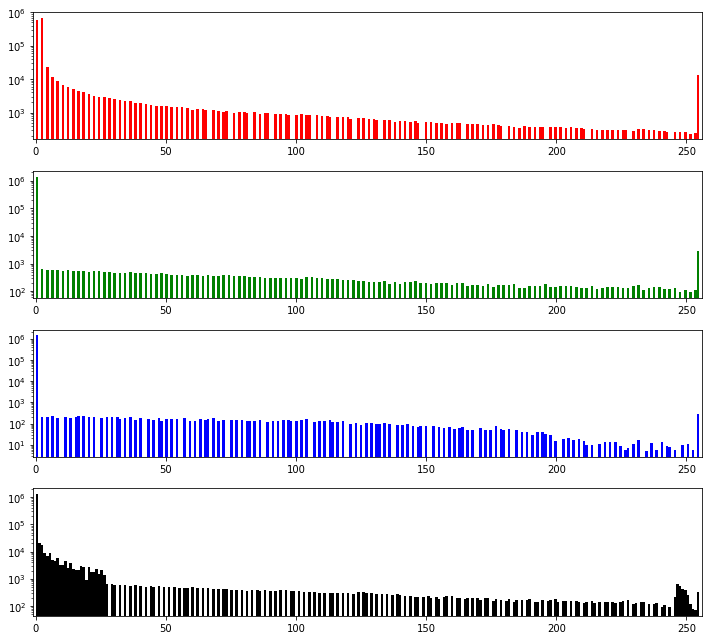

 
Maximum pixel value before removing hot pixels 255
Minimum pixel value  0
Type of raw image file is uint8
Type of greyscale image file is uint8
Number of rows 1040 of columns 1392 of pixels 1447680 and depth 3
Hot pixel cut 255
Number of hot pixels 0
Maximum pixel value after removing hot pixels 255
Minimum pixel value  0
 


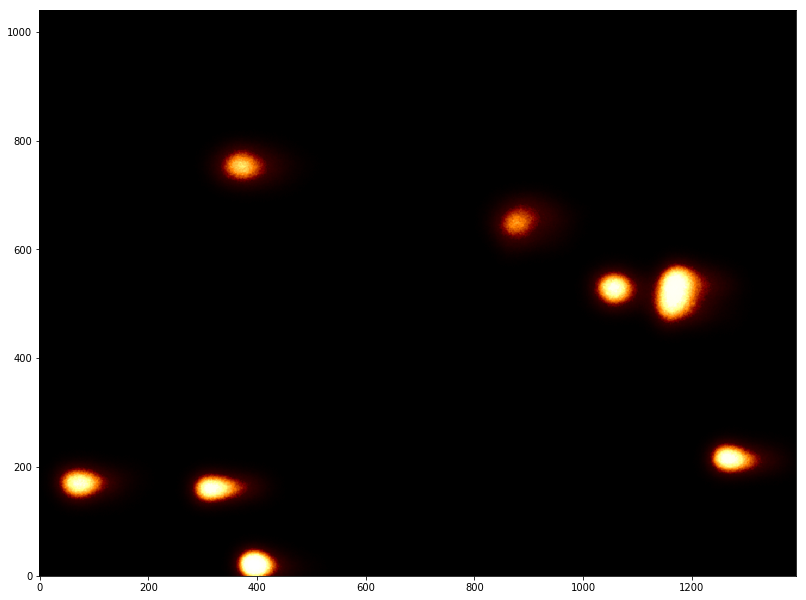

 
Date and time 2021-06-16 15:58:19.424909
Time since last check is 0:00:04.078266
Time since noteboook start is 0:00:04.078266


In [3]:
import datetime
now = datetime.datetime.now()
startNB = now
print("Date and time ",str(now))
print(" ")
#
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
%matplotlib inline
#
path = "CometImages/MCdata/pBreak080/*.bmp"
images = (glob.glob(path))
num_images = len(images)
debug = False
print(" ")
print("Look for images in directory \n",path)
print("Number found is",num_images)
#
# Set two thresholds for applying to image (lowest to highest)
thresh = np.array([20, 120])
#
# Set cut on hottest allowed pixels
hotCut = 255
hotCut = min(hotCut, 255)
print("Hottest allowed pixel intensity is",hotCut)
#
# Check that ine of the images looks sensible!
print(" ")
print("Example image",images[0])
imgRaw = plt.imread(images[0])
withHists = True
imgGrey, nRows, nCols = processImage(imgRaw, hotCut, withHists)
print(" ")
pltX = nCols/200
pltY = nRows/200
plt.figure(figsize = (2*pltX, 2*pltY))
plt.imshow(imgGrey, origin = 'lower', cmap = plt.get_cmap('afmhot'))
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since noteboook start is",str(now - startNB))

## Loop over all images in chosen directories and analyse

Date and time  2021-06-16 15:59:41.101818
 
List of image folders:
CometImages/MCdata/pBreak000/
CometImages/MCdata/pBreak010/
CometImages/MCdata/pBreak020/
CometImages/MCdata/pBreak030/
CometImages/MCdata/pBreak040/
CometImages/MCdata/pBreak050/
CometImages/MCdata/pBreak060/
CometImages/MCdata/pBreak070/
CometImages/MCdata/pBreak080/
CometImages/MCdata/pBreak090/
 
Cluster ID using Watershed algorithm
Cluster threshold 20.
Head low threshold 80, high threshold 180.
Min number of pixels in cluster 200, max number 200000.
Min number of pixels in head 40, max number 20000.
Width of expansion 9, useDiag = True
Up-down asymmetry cut 0.9
 
Look for images in directory 
 CometImages/MCdata/pBreak000/*.bmp
Number found is 40
File CometImages/MCdata/pBreak000/MCimage-pBreak000-007.bmp read.
------------------------------------------------------------------------------------
Running findWheels
 


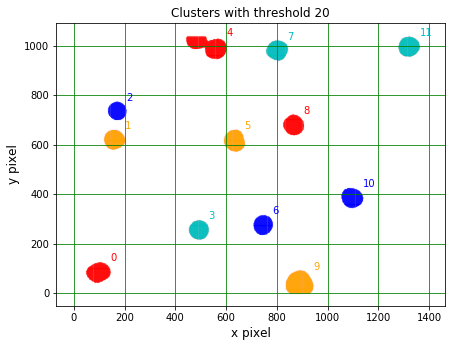

------------------------------------------------------------------------------------
Running clusExpand
 


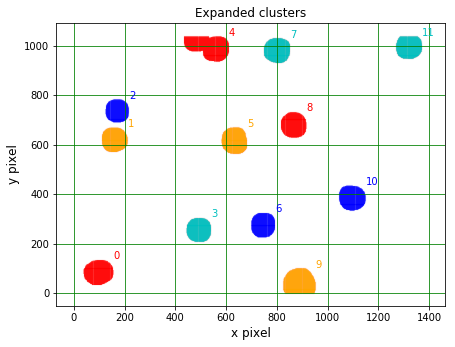

------------------------------------------------------------------------------------
Running findRims
 


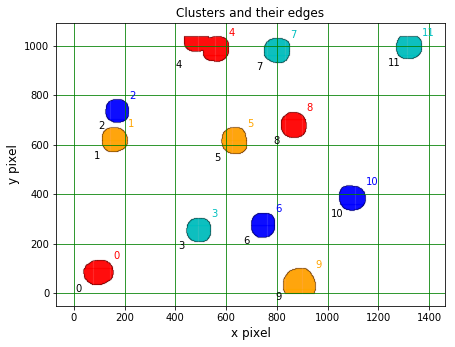

------------------------------------------------------------------------------------
Running selCometsThree
UseLowHead False
 


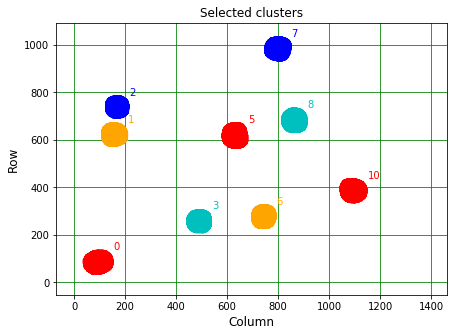

 
Number of selected clusters (nRimOut) 9
 
Remove the overlaps: []
 


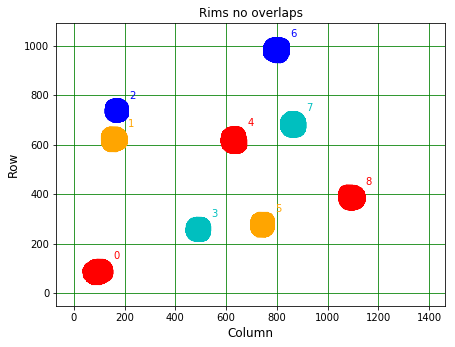

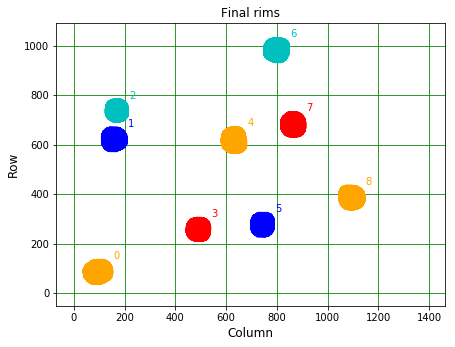

------------------------------------------------------------------------------------
Running calcQuads
 


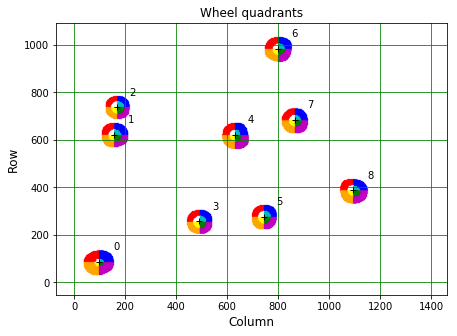

File CometImages/MCdata/pBreak000/MCimage-pBreak000-006.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-022.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-026.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-016.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-039.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-036.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-028.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-002.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-009.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-029.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-005.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-017.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-012.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-020.bmp read.
File CometImages/MCdata/pBreak000/MCimage-pBreak000-032.bmp read.
File Comet

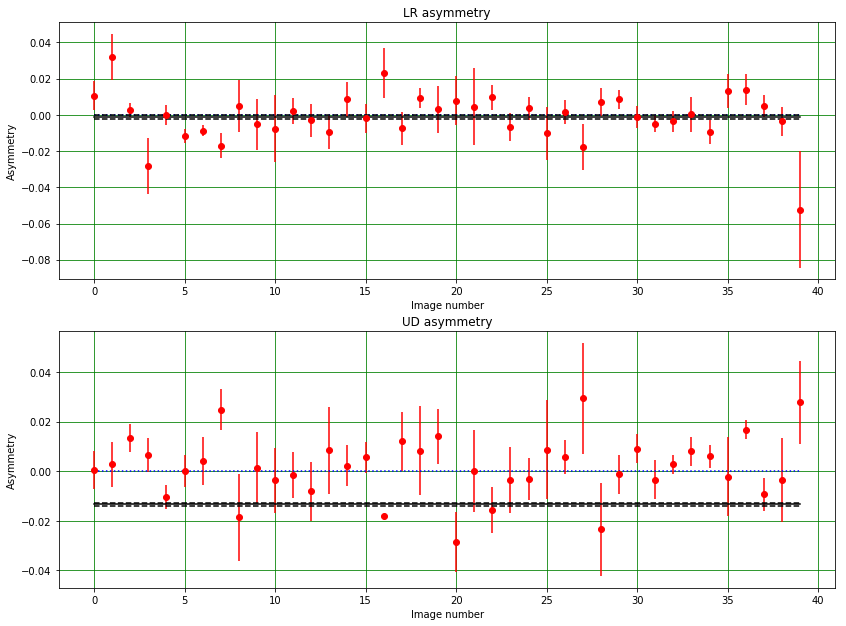

Look for images in directory 
 CometImages/MCdata/pBreak010/*.bmp
Number found is 40
File CometImages/MCdata/pBreak010/MCimage-pBreak010-013.bmp read.
File CometImages/MCdata/pBreak010/MCimage-pBreak010-022.bmp read.
File CometImages/MCdata/pBreak010/MCimage-pBreak010-026.bmp read.
No asymmetry (or asymmetry error) calculation possible.
File CometImages/MCdata/pBreak010/MCimage-pBreak010-028.bmp read.
File CometImages/MCdata/pBreak010/MCimage-pBreak010-019.bmp read.
File CometImages/MCdata/pBreak010/MCimage-pBreak010-024.bmp read.
File CometImages/MCdata/pBreak010/MCimage-pBreak010-011.bmp read.
File CometImages/MCdata/pBreak010/MCimage-pBreak010-001.bmp read.
File CometImages/MCdata/pBreak010/MCimage-pBreak010-032.bmp read.
File CometImages/MCdata/pBreak010/MCimage-pBreak010-021.bmp read.
File CometImages/MCdata/pBreak010/MCimage-pBreak010-000.bmp read.
File CometImages/MCdata/pBreak010/MCimage-pBreak010-020.bmp read.
File CometImages/MCdata/pBreak010/MCimage-pBreak010-039.bmp read.
F

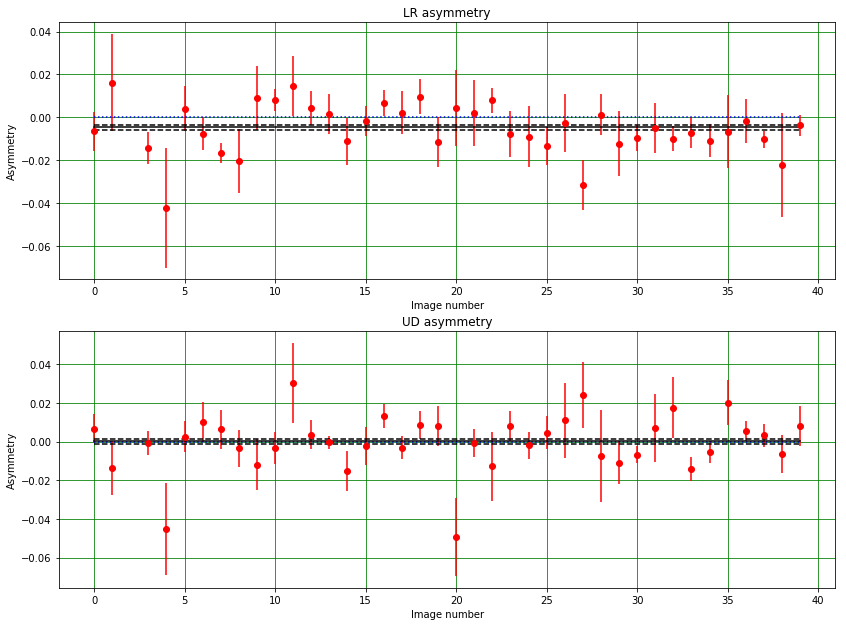

Look for images in directory 
 CometImages/MCdata/pBreak020/*.bmp
Number found is 40
File CometImages/MCdata/pBreak020/MCimage-pBreak020-013.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-034.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-006.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-009.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-029.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-020.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-010.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-026.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-038.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-024.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-008.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-002.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-027.bmp read.
File CometImages/MCdata/pBreak020/MCimage-pBreak020-003.b

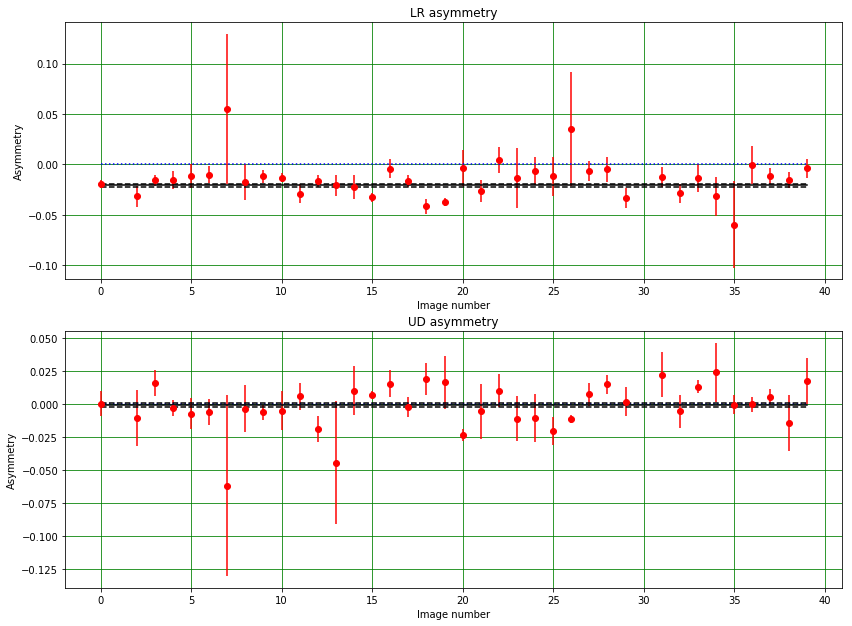

Look for images in directory 
 CometImages/MCdata/pBreak030/*.bmp
Number found is 40
File CometImages/MCdata/pBreak030/MCimage-pBreak030-006.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-018.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-021.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-036.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-004.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-016.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-025.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-019.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-026.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-000.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-037.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-017.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-003.bmp read.
File CometImages/MCdata/pBreak030/MCimage-pBreak030-031.b

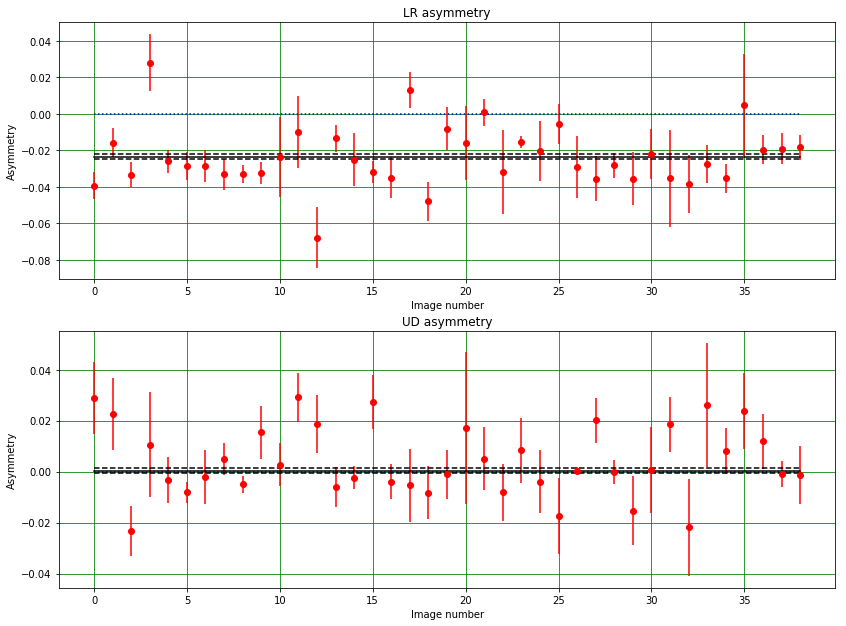

Look for images in directory 
 CometImages/MCdata/pBreak040/*.bmp
Number found is 40
File CometImages/MCdata/pBreak040/MCimage-pBreak040-003.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-036.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-020.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-039.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-006.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-009.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-026.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-007.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-035.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-017.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-030.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-031.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-004.bmp read.
File CometImages/MCdata/pBreak040/MCimage-pBreak040-025.b

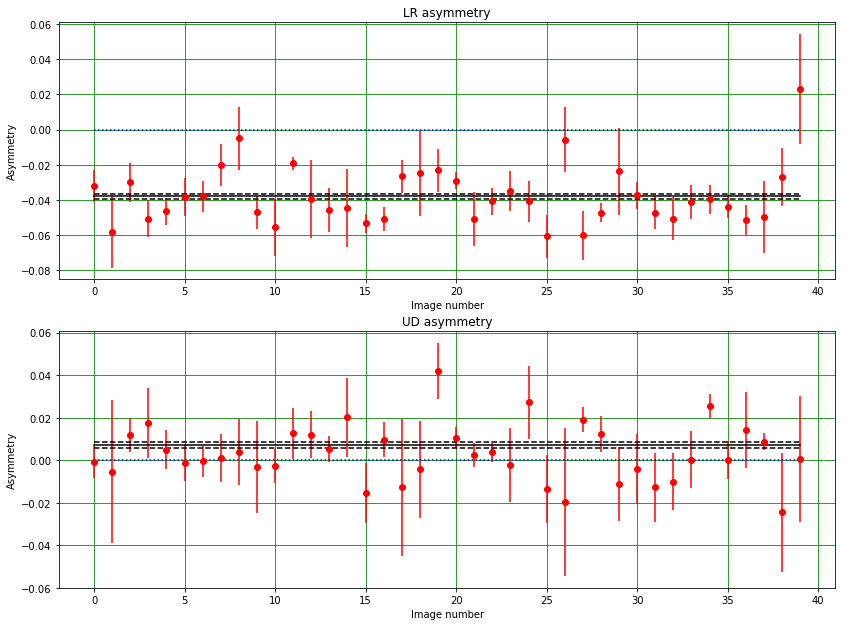

Look for images in directory 
 CometImages/MCdata/pBreak050/*.bmp
Number found is 40
File CometImages/MCdata/pBreak050/MCimage-pBreak050-028.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-020.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-016.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-009.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-015.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-022.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-025.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-001.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-026.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-013.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-007.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-005.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-019.bmp read.
File CometImages/MCdata/pBreak050/MCimage-pBreak050-004.b

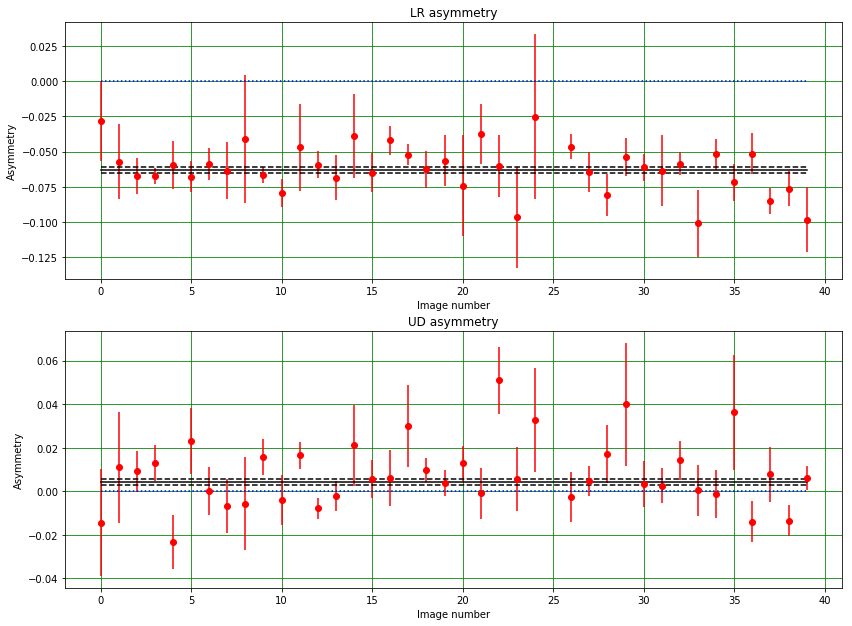

Look for images in directory 
 CometImages/MCdata/pBreak060/*.bmp
Number found is 40
File CometImages/MCdata/pBreak060/MCimage-pBreak060-032.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-029.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-026.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-024.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-021.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-010.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-007.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-022.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-035.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-003.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-002.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-016.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-033.bmp read.
File CometImages/MCdata/pBreak060/MCimage-pBreak060-001.b

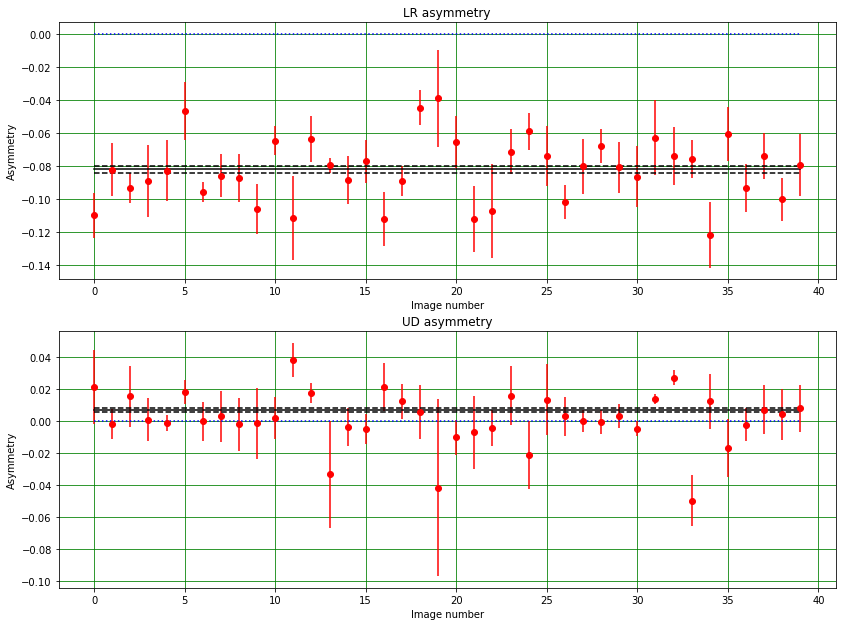

Look for images in directory 
 CometImages/MCdata/pBreak070/*.bmp
Number found is 40
File CometImages/MCdata/pBreak070/MCimage-pBreak070-022.bmp read.
File CometImages/MCdata/pBreak070/MCimage-pBreak070-018.bmp read.
No asymmetry (or asymmetry error) calculation possible.
File CometImages/MCdata/pBreak070/MCimage-pBreak070-032.bmp read.
File CometImages/MCdata/pBreak070/MCimage-pBreak070-037.bmp read.
File CometImages/MCdata/pBreak070/MCimage-pBreak070-023.bmp read.
File CometImages/MCdata/pBreak070/MCimage-pBreak070-015.bmp read.
File CometImages/MCdata/pBreak070/MCimage-pBreak070-017.bmp read.
File CometImages/MCdata/pBreak070/MCimage-pBreak070-026.bmp read.
File CometImages/MCdata/pBreak070/MCimage-pBreak070-010.bmp read.
File CometImages/MCdata/pBreak070/MCimage-pBreak070-028.bmp read.
File CometImages/MCdata/pBreak070/MCimage-pBreak070-009.bmp read.
File CometImages/MCdata/pBreak070/MCimage-pBreak070-029.bmp read.
File CometImages/MCdata/pBreak070/MCimage-pBreak070-024.bmp read.
F

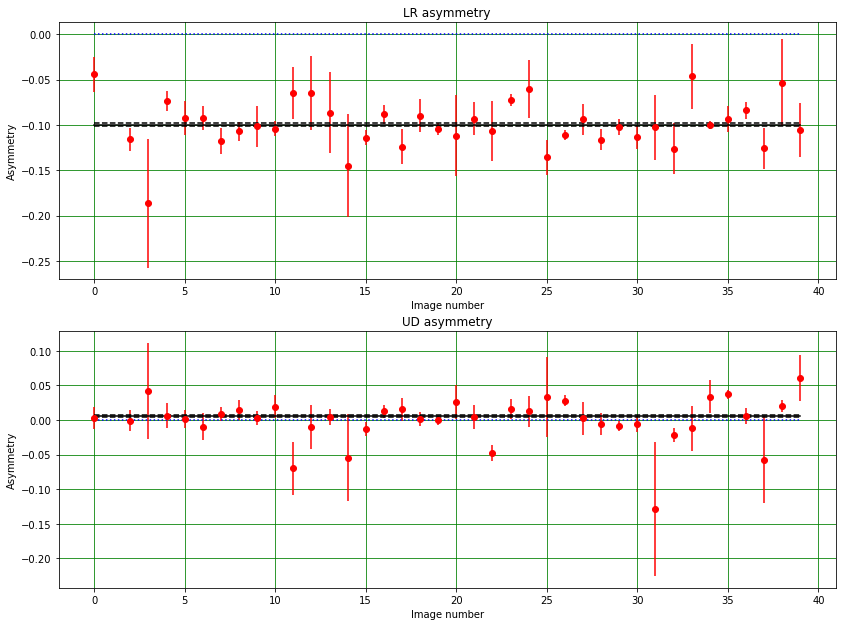

Look for images in directory 
 CometImages/MCdata/pBreak080/*.bmp
Number found is 40
File CometImages/MCdata/pBreak080/MCimage-pBreak080-033.bmp read.
File CometImages/MCdata/pBreak080/MCimage-pBreak080-007.bmp read.
File CometImages/MCdata/pBreak080/MCimage-pBreak080-016.bmp read.
File CometImages/MCdata/pBreak080/MCimage-pBreak080-014.bmp read.
File CometImages/MCdata/pBreak080/MCimage-pBreak080-004.bmp read.
File CometImages/MCdata/pBreak080/MCimage-pBreak080-010.bmp read.
No asymmetry (or asymmetry error) calculation possible.
File CometImages/MCdata/pBreak080/MCimage-pBreak080-020.bmp read.
File CometImages/MCdata/pBreak080/MCimage-pBreak080-012.bmp read.
File CometImages/MCdata/pBreak080/MCimage-pBreak080-006.bmp read.
File CometImages/MCdata/pBreak080/MCimage-pBreak080-037.bmp read.
File CometImages/MCdata/pBreak080/MCimage-pBreak080-039.bmp read.
No asymmetry (or asymmetry error) calculation possible.
File CometImages/MCdata/pBreak080/MCimage-pBreak080-031.bmp read.
File CometI

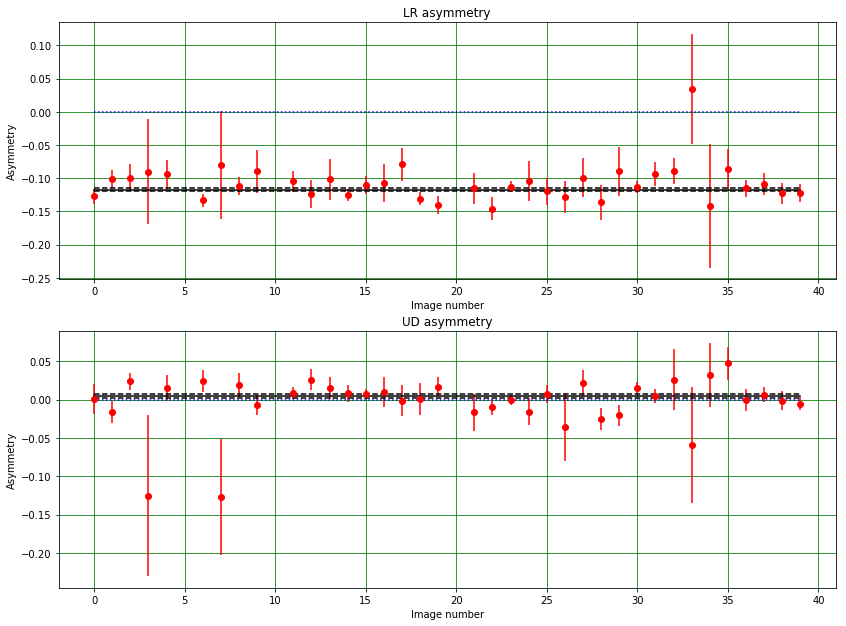

Look for images in directory 
 CometImages/MCdata/pBreak090/*.bmp
Number found is 14
File CometImages/MCdata/pBreak090/MCimage-pBreak090-009.bmp read.
File CometImages/MCdata/pBreak090/MCimage-pBreak090-001.bmp read.
File CometImages/MCdata/pBreak090/MCimage-pBreak090-013.bmp read.
No asymmetry (or asymmetry error) calculation possible.
File CometImages/MCdata/pBreak090/MCimage-pBreak090-000.bmp read.
File CometImages/MCdata/pBreak090/MCimage-pBreak090-012.bmp read.
File CometImages/MCdata/pBreak090/MCimage-pBreak090-003.bmp read.
File CometImages/MCdata/pBreak090/MCimage-pBreak090-004.bmp read.
File CometImages/MCdata/pBreak090/MCimage-pBreak090-002.bmp read.
File CometImages/MCdata/pBreak090/MCimage-pBreak090-005.bmp read.
File CometImages/MCdata/pBreak090/MCimage-pBreak090-008.bmp read.
File CometImages/MCdata/pBreak090/MCimage-pBreak090-011.bmp read.
File CometImages/MCdata/pBreak090/MCimage-pBreak090-007.bmp read.
File CometImages/MCdata/pBreak090/MCimage-pBreak090-006.bmp read.
F

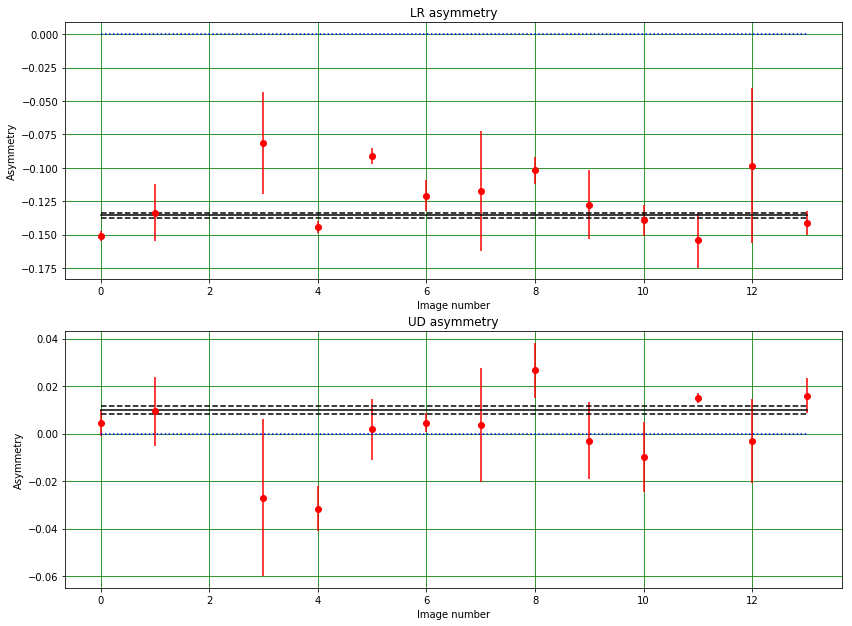

 
Date and time 2021-06-16 16:29:48.423539
Time since last check is 0:30:07.321721
Time since notebook start is 0:31:33.076896


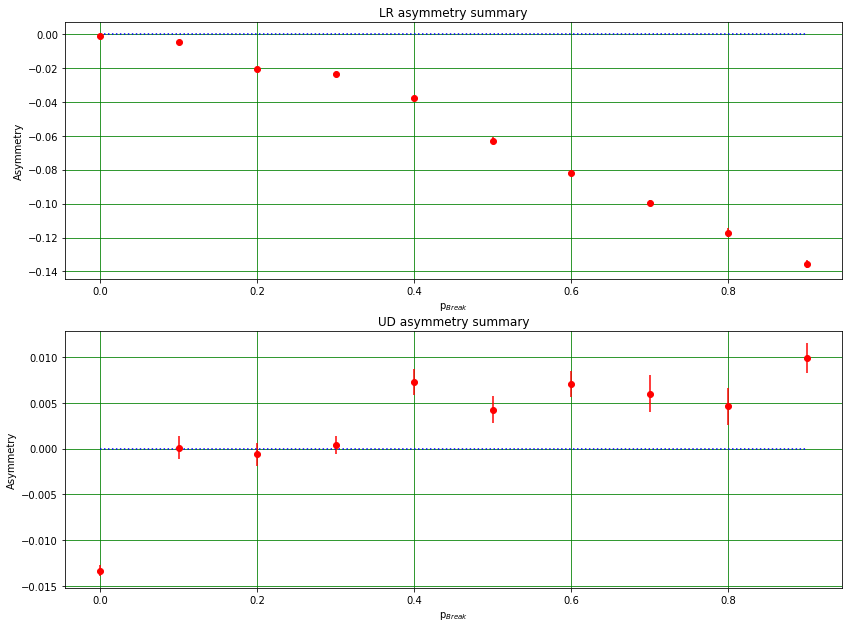

In [4]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
debug = False
debugHere = False
#
pathDir00 = "CometImages/MCdata/pBreak000/"
pathDir01 = "CometImages/MCdata/pBreak010/"
pathDir02 = "CometImages/MCdata/pBreak020/"
pathDir03 = "CometImages/MCdata/pBreak030/"
pathDir04 = "CometImages/MCdata/pBreak040/"
pathDir05 = "CometImages/MCdata/pBreak050/"
pathDir06 = "CometImages/MCdata/pBreak060/"
pathDir07 = "CometImages/MCdata/pBreak070/"
pathDir08 = "CometImages/MCdata/pBreak080/"
pathDir09 = "CometImages/MCdata/pBreak090/"
#
dirList = [pathDir00, pathDir01, pathDir02, pathDir03, pathDir04, pathDir05, pathDir06, pathDir07, pathDir08, pathDir09]
#dirList = [pathDir08, pathDir09]
#dirList = [pathDir06]
print(" ")
print("List of image folders:")
for folder in dirList:
    print(folder)
#
pltX = nCols/200
pltY = nRows/200
#
# Set three thresholds for applying to image (lowest to highest)
thresh = np.array([20, 80, 180])
nThresh = len(thresh)
if nThresh != 3:
    print(" ")
    print("nThresh =",nThresh," not allowed. Must be 3. Stop program!")
    sys.exit()

imgThr = np.zeros((nRows, nCols, nThresh))
#
# Requirements on minimum and maximum number of pixels in wheels at the cluster threshold
minClusPixels = 200
maxClusPixels = 200000
#
# Requirements on minimum and maximum number of pixels in wheels at the head threshold(s)
minHeadPixels = 40
maxHeadPixels = 20000
#
print(" ")
print("Cluster ID using Watershed algorithm")
print("Cluster threshold",thresh[0],"\b.")
print("Head low threshold",thresh[1],"\b, high threshold",thresh[2],"\b.")
print("Min number of pixels in cluster",minClusPixels,"\b, max number",maxClusPixels,"\b.")
print("Min number of pixels in head",minHeadPixels,"\b, max number",maxHeadPixels,"\b.")
#
# Colour table for plots
nColTab = 4
colorTab = ['r', 'orange', 'b', 'c']
#
# Define grid of markers and background marker value:
nStepCols = 3
nStepRows = 3
#
# Ensure rMark + 1 (used later) doesn't cause overflow in number of image rows (i.e. rMark + 1 < nRows)
if nRows%nStepRows > 1:
    rMarkTop = nRows
else:
    rMarkTop = nRows - nStepRows
rMark, cMark = np.ogrid[0:rMarkTop:nStepRows, 0:nCols:nStepCols]
if debug:
    print(" ")
    print("rMark.shape",rMark.shape,"cMark.shape",cMark.shape)
#
mStart = 1
markers = np.zeros((nRows, nCols)).astype(int)
markers[rMark, cMark] = rMark/nStepRows + cMark*nRows/(nStepRows*nStepCols) + mStart
if debugHere:
    plt.figure(figsize = (pltX, pltY))
    plt.imshow(markers, cmap = "CMRmap");
#
useDiag = True
widthEx = 9
aUDcut = 0.9
print("Width of expansion",widthEx,"\b, useDiag =",useDiag)
print("Up-down asymmetry cut",aUDcut)
#
maxWheels = 24
#
num_dirs = len(dirList)
#
avgALR = np.zeros(num_dirs)
errALR = np.zeros(num_dirs)
avgAUD = np.zeros(num_dirs)
errAUD = np.zeros(num_dirs)
#
print(" ")
for nd in range(0, num_dirs):
    path = dirList[nd] + "*.bmp"
    images = (glob.glob(path))
    num_images = len(images)
    asymmLR = np.zeros(num_images)
    asymmUD = np.zeros(num_images)
    aErrLR = np.zeros(num_images)
    aErrUD = np.zeros(num_images)
    print("Look for images in directory \n",path)
    print("Number found is",num_images)
    useImage = np.zeros(num_images).astype(bool)
    for im in range(0, num_images):
        imgRaw = plt.imread(images[im])
        print("File " + images[im] + " read.")
        if debugHere:
            plt.figure(figsize = (pltX, pltY))
            plt.imshow(imgRaw, origin = 'lower', cmap = plt.get_cmap('afmhot'))
            plt.show()
        #
        # Perform initial image prcsessing (convert to grey and apply hot pixel cut)
        withHists = False
        imgGrey, nRows, nCols = processImage(imgRaw, hotCut, withHists)
        #
        # Find wheels using cluster (lowest) threshold
        nInClus, rPixCl, cPixCl, iPixCl = findWheels(imgGrey, thresh[0])
        #
        # Find wheels using low head threshold
        nInHdL, rPixHdL, cPixHdL, iPixHdL = findWheels(imgGrey, thresh[1])
        #
        # Find wheels using high head threshold
        nInHdH, rPixHdH, cPixHdH, iPixHdH = findWheels(imgGrey, thresh[2])
        #
        # Expand clusters
        nInClEx, rPixClEx, cPixClEx, iPixClEx, nInClEd, rPixClEd, cPixClEd, iPixClEd = \
        clusExpand(nInClus, rPixCl, cPixCl, widthEx)
        #
        # Find rims of expanded clusters
        nInClExEd, rPixClExEd, cPixClExEd, iPixClExEd = findRims(nInClEx, rPixClEx, cPixClEx)
        #
        # Find rims of low threshold head
        nInHdEdL, rPixHdEdL, cPixHdEdL, iPixHdEdL = findRims(nInHdL, rPixHdL, cPixHdL)
        #
        # Find rims of high threshold head
        nInHdEdH, rPixHdEdH, cPixHdEdH, iPixHdEdH = findRims(nInHdH, rPixHdH, cPixHdH)
        #
        # Select comets, three threshold analysis
        nWheels, pnts_num, pnts_row, pnts_col, mean_row, mean_col, head_num, head_row, head_col = \
        selCometsThree(nInClEx, rPixClEx, cPixClEx, nInClExEd, rPixClExEd, cPixClExEd, 
                       nInHdL, rPixHdL, cPixHdL, nInHdEdL, rPixHdEdL, cPixHdEdL,
                       nInHdH, rPixHdH, cPixHdH, nInHdEdH, rPixHdEdH, cPixHdEdH) 
        #
        if nWheels > maxWheels:
            print("Maximum number of wheels exceeded.")
            useImage[im] = False
            continue
        elif nWheels > 0:
            sumULwheel, sumLLwheel, sumURwheel, sumLRwheel, sumULhead, sumLLhead, sumURhead, sumLRhead = \
            calcQuads(nWheels, pnts_num, pnts_row, pnts_col, mean_row, mean_col, head_num, head_row, head_col)
            #
            sumAllunsel = sumULwheel + sumLLwheel + sumURwheel + sumLRwheel
            aUDunsel = (sumULwheel + sumURwheel - sumLLwheel - sumLRwheel)/sumAllunsel
            boolAsel = abs(aUDunsel) < aUDcut
            nSel = np.sum(boolAsel)
            sumAll = sumULwheel[boolAsel] + sumLLwheel[boolAsel] + sumURwheel[boolAsel] + sumLRwheel[boolAsel]
            aUD = (sumULwheel[boolAsel] + sumURwheel[boolAsel] - sumLLwheel[boolAsel] - sumLRwheel[boolAsel])/sumAll
            aLR = (sumULwheel[boolAsel] + sumLLwheel[boolAsel] - sumURwheel[boolAsel] - sumLRwheel[boolAsel])/sumAll
            if nSel > 1:
                asymmUD[im] = np.mean(aUD)
                asymmLR[im] = np.mean(aLR)
                aErrUD[im] = np.std(aUD, ddof = 1)/np.sqrt(nSel)
                aErrLR[im] = np.std(aLR, ddof = 1)/np.sqrt(nSel)
                useImage[im] = True
            #elif nSel > 0:
            #    asymmUD[im] = np.mean(aUD)
            #    asymmLR[im] = np.mean(aLR)
            #    aErrUD[im] = 0.02
            #    aErrLR[im] = 0.02
            #    useImage[im] = True
            else:
                print("No asymmetry (or asymmetry error) calculation possible.")
                useImage[im] = False
        else:
            useImage[im] = False
        # End of loop over images
        #
    avgALR[nd] = np.sum(asymmLR[useImage]/aErrLR[useImage]**2)/np.sum(1/aErrLR[useImage]**2)
    errALR[nd] = np.sqrt(1/np.sum(1/aErrLR[useImage]**2))
    avgAUD[nd] = np.sum(asymmUD[useImage]/aErrUD[useImage]**2)/np.sum(1/aErrUD[useImage]**2)
    errAUD[nd] = np.sqrt(1/np.sum(1/aErrUD[useImage]**2))
    #
    xPoints = np.linspace(0, num_images - 1, num_images)
    yOnes = np.ones(num_images)
    #
    fig, axs = plt.subplots(2, figsize = (2*pltX, 2*pltY))
    axs[0].set_title("LR asymmetry")
    axs[0].errorbar(xPoints[useImage], asymmLR[useImage], yerr = aErrLR[useImage], 
                    linestyle = '', color = 'r', marker = 'o')
    axs[0].plot(xPoints[useImage], np.zeros(num_images)[useImage], linestyle = ":", color = 'b')
    axs[0].plot(xPoints[useImage], avgALR[nd]*yOnes[useImage], linestyle = '-', color = 'k')
    axs[0].plot(xPoints[useImage], (avgALR[nd] + errALR[nd])*yOnes[useImage], linestyle = '--', color = 'k')
    axs[0].plot(xPoints[useImage], (avgALR[nd] - errALR[nd])*yOnes[useImage], linestyle = '--', color = 'k')
    axs[0].set_xlabel("Image number")
    axs[0].set_ylabel("Asymmetry")
    axs[0].grid(color = 'g')
    #
    axs[1].set_title("UD asymmetry")
    axs[1].errorbar(xPoints[useImage], asymmUD[useImage], yerr = aErrUD[useImage],
                    linestyle = '', color = 'r', marker = 'o') 
    axs[1].plot(xPoints[useImage], np.zeros(num_images)[useImage], linestyle = ":", color = 'b')
    axs[1].plot(xPoints[useImage], avgAUD[nd]*yOnes[useImage], linestyle = '-', color = 'k')
    axs[1].plot(xPoints[useImage], (avgAUD[nd] + errAUD[nd])*yOnes[useImage], linestyle = '--', color = 'k')
    axs[1].plot(xPoints[useImage], (avgAUD[nd] - errAUD[nd])*yOnes[useImage], linestyle = '--', color = 'k')
    axs[1].set_xlabel("Image number")
    axs[1].set_ylabel("Asymmetry")
    axs[1].grid(color = 'g')
    #
    plt.tight_layout
    plt.show()
#
xPlot = 0.1*np.linspace(0, num_dirs - 1, num_dirs)
yOnes = np.ones(num_dirs)
#
fig, axs = plt.subplots(2, figsize = (2*pltX, 2*pltY))
axs[0].set_title("LR asymmetry summary")
axs[0].errorbar(xPlot, avgALR, yerr = errALR, linestyle = '', color = 'r', marker = 'o')
axs[0].plot(xPlot, np.zeros(num_dirs), linestyle = ":", color = 'b')
axs[0].set_xlabel("p$_{Break}$")
axs[0].set_ylabel("Asymmetry")
axs[0].grid(color = 'g')
#
axs[1].set_title("UD asymmetry summary")
axs[1].errorbar(xPlot, avgAUD, yerr = errAUD, linestyle = '', color = 'r', marker = 'o') 
axs[1].plot(xPlot, np.zeros(num_dirs), linestyle = ":", color = 'b')
axs[1].set_xlabel("p$_{Break}$")
axs[1].set_ylabel("Asymmetry")
axs[1].grid(color = 'g')
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since notebook start is",str(now - startNB))

## Fit inverse asymmetry

This is the function used to extract $p_{break}$ from a measured asymmetry. First plot the data (inverting $x$ and $y$ axes).

In [6]:
import sys
sys.version

'3.5.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 13:47:34) \n[GCC 7.2.0]'

Date and time  2021-06-16 16:38:55.387371
 
Index	 Asymmetry	 Error	 pBreak	 Error
0 	 -0.0011	 0.0011	 0.0000	 0.0289
1 	 -0.0047	 0.0013	 0.1000	 0.0289
2 	 -0.0205	 0.0013	 0.2000	 0.0289
3 	 -0.0235	 0.0014	 0.3000	 0.0289
4 	 -0.0380	 0.0014	 0.4000	 0.0289
5 	 -0.0629	 0.0019	 0.5000	 0.0289
6 	 -0.0820	 0.0019	 0.6000	 0.0289
7 	 -0.0996	 0.0019	 0.7000	 0.0289
8 	 -0.1171	 0.0026	 0.8000	 0.0289
9 	 -0.1357	 0.0022	 0.9000	 0.0289


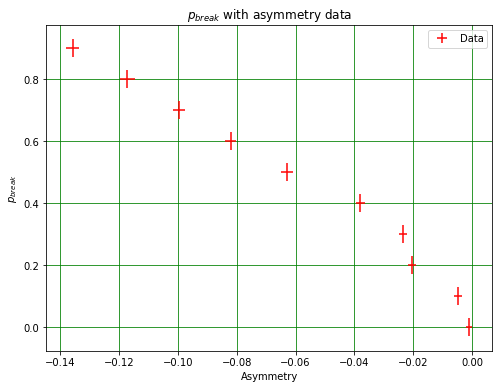

 
Date and time 2021-06-16 16:38:55.604543
Time since last check is 0:00:00.217172
Time since notebook start is 0:40:40.257900


In [10]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
nPoints = len(xPlot)
yData = xPlot
xData = avgALR
yError = 0.1/np.sqrt(12)*np.ones(len(xData)) 
xError = errALR
print(" ")
print("Index\t Asymmetry\t Error\t pBreak\t Error")
for i in range(0,  nPoints):
    #print(f"{i}\t {xData[i]:.4f}\t\t {xError[i]:.4f}\t {yData[i]:.4f}\t {yError[i]:.4f}")
    print("{} \t {:.4f}\t {:.4f}\t {:.4f}\t {:.4f}".format(i, xData[i], xError[i], yData[i], yError[i]))
#
# Plot data
fig = plt.figure(figsize = (8, 6))
plt.title('$p_{break}$ with asymmetry data')
plt.xlabel('Asymmetry')
plt.ylabel('$p_{break}$')
plt.errorbar(xData, yData, xerr = xError, yerr = yError, fmt='r', \
             linestyle = '', label = "Data") 
#plt.xlim(1.0, 7.0)
#plt.ylim(0.0, 3.0)
plt.grid(color = 'g')
plt.legend()
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since notebook start is",str(now - startNB))

Date and time  2021-06-16 16:39:03.281745
 
Fit quality:
chisq per point = 
 [3.23553 0.20495 0.28488 3.86806 2.76004 0.34891 1.0917  0.63689 0.01642
 0.65075]
chisq = 13.10, chisq/NDF =  1.87.
 
Parameters returned by fit:
a = 0.0451 +- 0.0203
b = -8.7347 +- 0.8094
c = -19.2446 +- 5.9384
 


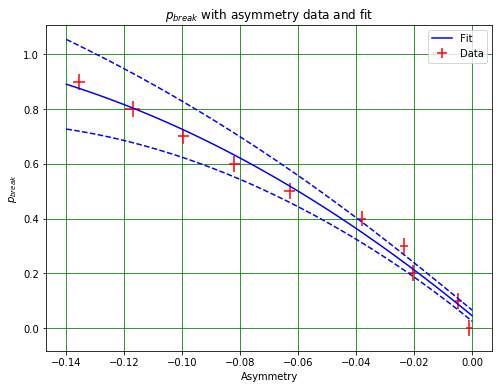

 
Date and time 2021-06-16 16:39:03.681494
Time since last check is 0:00:00.399749
Time since notebook start is 0:40:48.334851


In [11]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
from scipy.optimize import least_squares
#
goodPoints = np.logical_not(np.isnan(avgALR))
yData = xPlot[goodPoints]
xData = avgALR[goodPoints]
yError = 0.1/np.sqrt(12)*np.ones(len(avgALR))[goodPoints] 
xError = errALR[goodPoints]
nPoints = len(xPlot[goodPoints])
#
def fitLine(p, x):
    '''
    Quadratic
    '''
    f = p[0] + p[1]*x + p[2]*x**2
    return f
#
def fitLineDiff(p, x):
    '''
    Differential of fitLine
    '''
    df = p[1] + 2*p[2]*x
    return df
#
def fitChi(p, x, y, xerr, yerr):
    '''
    Cost function
    '''
    e = (y - fitLine(p, x))/(np.sqrt(yerr**2 + fitLineDiff(p, x)**2*xerr**2))
    return e
#
def fitLineErr(p, pe, x):
    '''
    Quadratic function error given errors on fitted parameters
    '''
    fe = np.sqrt((pe[0])**2 + (x*pe[1])**2 + (x**2*pe[2])**2)
    return fe
#
# Set initial values of fit parameters, run fit
pInit = [0.1, -10.0, -20.0]
out = least_squares(fitChi, pInit, args=(xData, yData, xError, yError))
#
fitOK = out.success
#
# Test if fit failed
if not fitOK:
    print(" ")
    print("Fit failed")
else:
    #
    # get output
    pFinal = out.x
    aVal = pFinal[0]
    bVal = pFinal[1]
    cVal = pFinal[2]
    #
    #   Calculate chis**2 per point, summed chi**2 and chi**2/NDF
    chisqArr = fitChi(pFinal, xData, yData, xError, yError)**2
    chisq = np.sum(chisqArr)
    NDF = nPoints - 3
    redchisq = chisq/NDF
#
    np.set_printoptions(precision = 5)
    print(" ")
    print("Fit quality:")
    print("chisq per point = \n",chisqArr)
    print("chisq = {:5.2f}, chisq/NDF = {:5.2f}.".format(chisq, redchisq))
    #
    # Compute covariance
    jMat = out.jac
    jMat2 = np.dot(jMat.T, jMat)
    detJmat2 = np.linalg.det(jMat2)
    #
    if detJmat2 < 1E-32:
        print("Value of determinat detJmat2",detJmat2)
        print("Matrix singular, error calculation failed.")
        print(" ")
        print("Parameters returned by fit:")
        print("a = {:5.3f}".format(aVal))
        print("b = {:5.3f}".format(bVal))
        print("c = {:5.3f}".format(cVal))
        print(" ")
        aErr = 0.0
        bErr = 0.0
        cErr = 0.0
    else:
        covar = np.linalg.inv(jMat2)
        aErr = np.sqrt(covar[0, 0])
        bErr = np.sqrt(covar[1, 1])
        cErr = np.sqrt(covar[2, 2])
        #
        print(" ")
        print("Parameters returned by fit:")
        print("a = {:6.4f} +- {:6.4f}".format(aVal, aErr))
        print("b = {:6.4f} +- {:6.4f}".format(bVal, bErr))
        print("c = {:6.4f} +- {:6.4f}".format(cVal, cErr))
        print(" ")
    #
    # Calculate fitted function values
    fitData = fitLine(pFinal, xData)
    pError = np.zeros(3)
    pError[0] = aErr
    pError[1] = bErr
    pError[2] = cErr
    xErrPlot = np.linspace(-0.14, 0, 50)
    fitDataErr = fitLine(pFinal, xErrPlot)
    fitErr = fitLineErr(pFinal, pError, xErrPlot)
    #
    # Plot data
    fig = plt.figure(figsize = (8, 6))
    plt.title('$p_{break}$ with asymmetry data and fit')
    plt.xlabel('Asymmetry')
    plt.ylabel('$p_{break}$')
    plt.errorbar(xData, yData, xerr = xError, yerr = yError, fmt='r', \
                 linestyle = '', label = "Data") 
    plt.plot(xErrPlot, fitDataErr, color = 'b', linestyle = '-', label = "Fit")
    plt.plot(xErrPlot, fitDataErr + fitErr, color = 'b', linestyle = '--')
    plt.plot(xErrPlot, fitDataErr - fitErr, color = 'b', linestyle = '--')
    #plt.xlim(1.0, 7.0)
    #plt.ylim(0.0, 3.0)
    plt.grid(color = 'g')
    plt.legend()
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since notebook start is",str(now - startNB))

## Determine asymmetry test images

Use parameters set in above cells for image analysis so above function is appropriate!

Date and time  2021-06-16 16:41:10.814042
 
Cluster ID using Watershed algorithm
Cluster threshold 20.
Head low threshold 80, high threshold 180.
Min number of pixels in cluster 200, max number 200000.
Min number of pixels in head 40, max number 20000.
Width of expansion 9, useDiag = True
Up-down asymmetry cut 0.9
 
List of image folders:
CometImages/MCdata/pBreak045/
CometImages/MCdata/pBreak055/
CometImages/MCdata/pBreak065/
CometImages/MCdata/pBreak075/
CometImages/MCdata/pBreak085/
 
Look for images in directory 
 CometImages/MCdata/pBreak045/*.bmp
Number found is 40
File CometImages/MCdata/pBreak045/MCimage-pBreak045-001.bmp read.
File CometImages/MCdata/pBreak045/MCimage-pBreak045-018.bmp read.
File CometImages/MCdata/pBreak045/MCimage-pBreak045-027.bmp read.
File CometImages/MCdata/pBreak045/MCimage-pBreak045-005.bmp read.
File CometImages/MCdata/pBreak045/MCimage-pBreak045-020.bmp read.
File CometImages/MCdata/pBreak045/MCimage-pBreak045-032.bmp read.
File CometImages/MCdata/pB

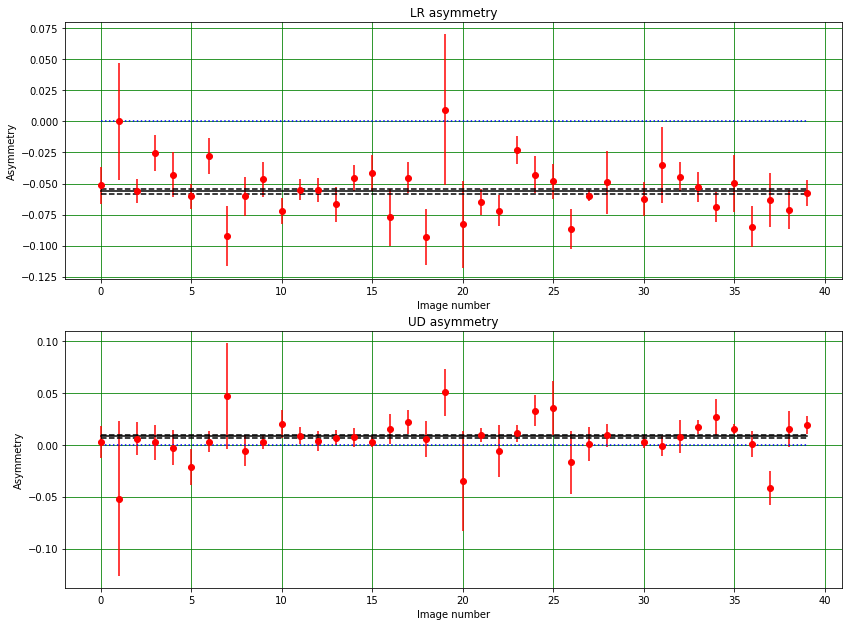

Look for images in directory 
 CometImages/MCdata/pBreak055/*.bmp
Number found is 40
File CometImages/MCdata/pBreak055/MCimage-pBreak055-033.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-031.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-011.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-016.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-006.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-027.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-007.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-032.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-039.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-018.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-035.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-019.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-010.bmp read.
File CometImages/MCdata/pBreak055/MCimage-pBreak055-022.b

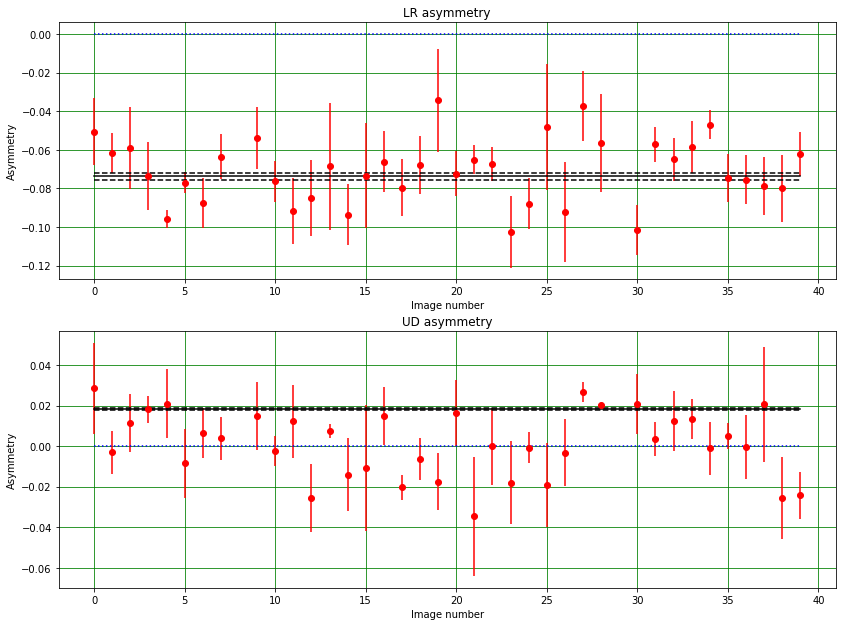

Look for images in directory 
 CometImages/MCdata/pBreak065/*.bmp
Number found is 40
File CometImages/MCdata/pBreak065/MCimage-pBreak065-019.bmp read.
No asymmetry (or asymmetry error) calculation possible.
File CometImages/MCdata/pBreak065/MCimage-pBreak065-004.bmp read.
File CometImages/MCdata/pBreak065/MCimage-pBreak065-009.bmp read.
File CometImages/MCdata/pBreak065/MCimage-pBreak065-002.bmp read.
File CometImages/MCdata/pBreak065/MCimage-pBreak065-013.bmp read.
File CometImages/MCdata/pBreak065/MCimage-pBreak065-006.bmp read.
File CometImages/MCdata/pBreak065/MCimage-pBreak065-028.bmp read.
File CometImages/MCdata/pBreak065/MCimage-pBreak065-010.bmp read.
File CometImages/MCdata/pBreak065/MCimage-pBreak065-016.bmp read.
File CometImages/MCdata/pBreak065/MCimage-pBreak065-039.bmp read.
File CometImages/MCdata/pBreak065/MCimage-pBreak065-025.bmp read.
File CometImages/MCdata/pBreak065/MCimage-pBreak065-026.bmp read.
File CometImages/MCdata/pBreak065/MCimage-pBreak065-033.bmp read.
F

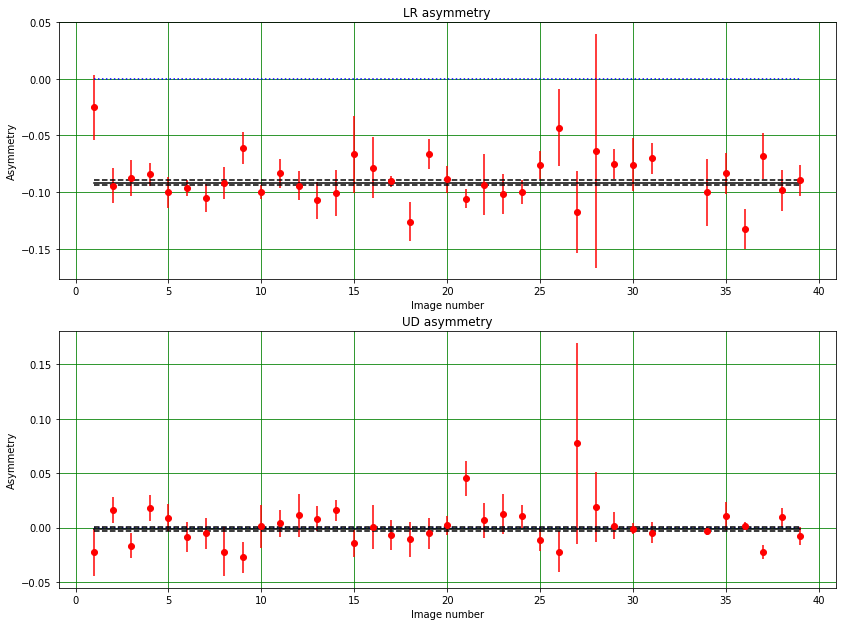

Look for images in directory 
 CometImages/MCdata/pBreak075/*.bmp
Number found is 39
File CometImages/MCdata/pBreak075/MCimage-pBreak075-039.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-017.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-006.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-028.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-003.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-008.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-030.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-005.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-007.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-000.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-022.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-036.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-009.bmp read.
File CometImages/MCdata/pBreak075/MCimage-pBreak075-013.b

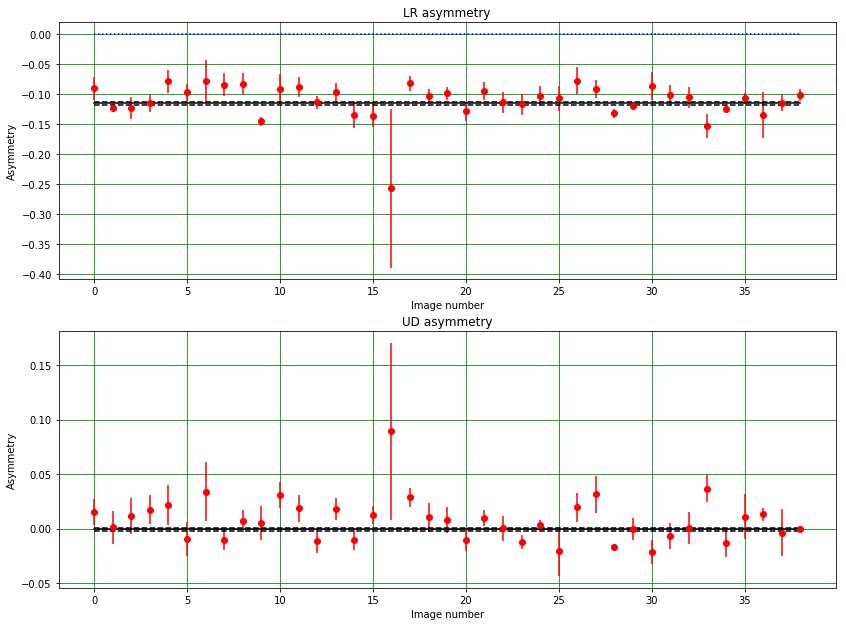

Look for images in directory 
 CometImages/MCdata/pBreak085/*.bmp
Number found is 40
File CometImages/MCdata/pBreak085/MCimage-pBreak085-022.bmp read.
File CometImages/MCdata/pBreak085/MCimage-pBreak085-038.bmp read.
File CometImages/MCdata/pBreak085/MCimage-pBreak085-007.bmp read.
File CometImages/MCdata/pBreak085/MCimage-pBreak085-024.bmp read.
File CometImages/MCdata/pBreak085/MCimage-pBreak085-017.bmp read.
File CometImages/MCdata/pBreak085/MCimage-pBreak085-004.bmp read.
File CometImages/MCdata/pBreak085/MCimage-pBreak085-028.bmp read.
File CometImages/MCdata/pBreak085/MCimage-pBreak085-035.bmp read.
File CometImages/MCdata/pBreak085/MCimage-pBreak085-006.bmp read.
File CometImages/MCdata/pBreak085/MCimage-pBreak085-008.bmp read.
File CometImages/MCdata/pBreak085/MCimage-pBreak085-036.bmp read.
No asymmetry (or asymmetry error) calculation possible.
File CometImages/MCdata/pBreak085/MCimage-pBreak085-003.bmp read.
File CometImages/MCdata/pBreak085/MCimage-pBreak085-037.bmp read.
F

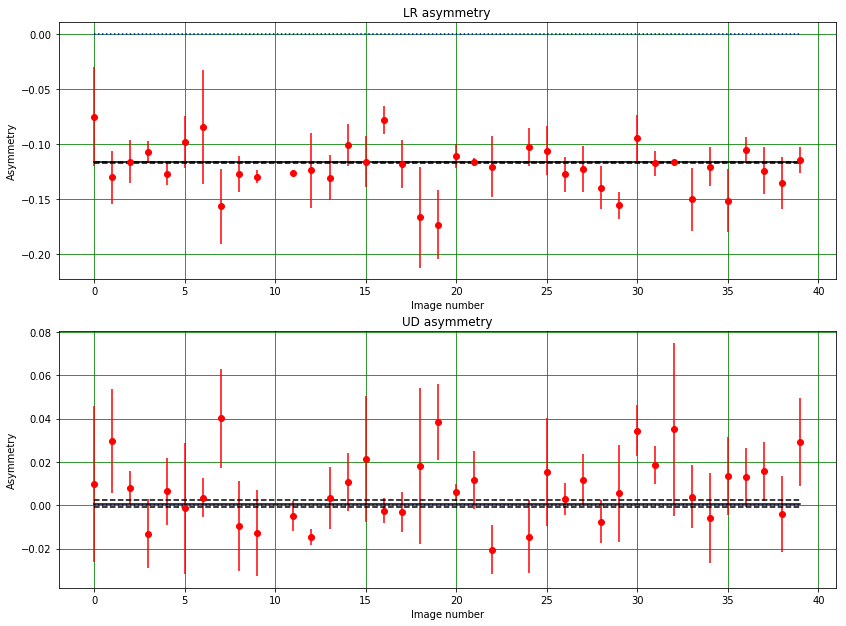

 
Folder	 Average LR asymmetry	 Error
0	 -0.0564	 0.0020
1	 -0.0738	 0.0019
2	 -0.0918	 0.0021
3	 -0.1156	 0.0019
4	 -0.1168	 0.0004
 
Date and time 2021-06-16 16:57:18.737937
Time since last check is 0:16:07.923895
Time since notebook start is 0:59:03.391294


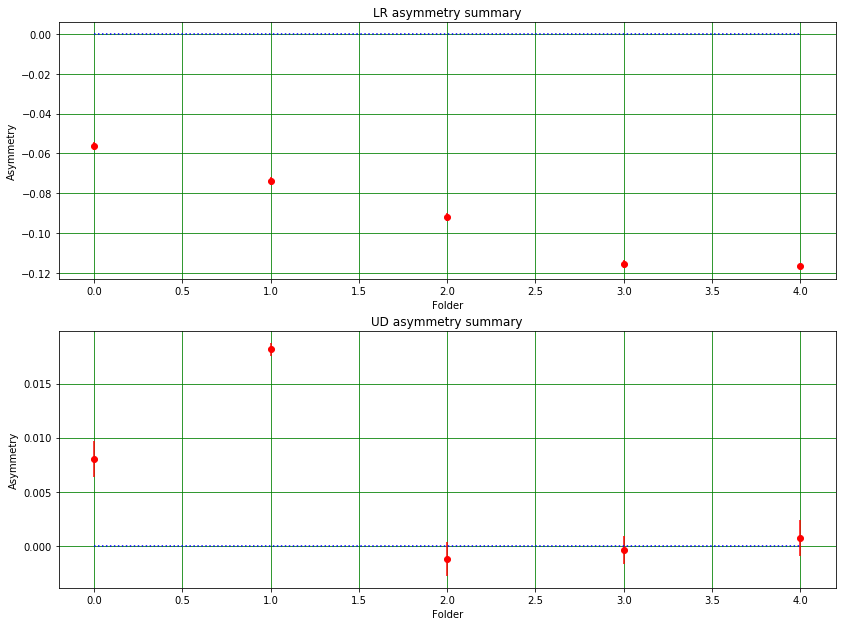

In [14]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
debug = False
#
print(" ")
print("Cluster ID using Watershed algorithm")
print("Cluster threshold",thresh[0],"\b.")
print("Head low threshold",thresh[1],"\b, high threshold",thresh[2],"\b.")
print("Min number of pixels in cluster",minClusPixels,"\b, max number",maxClusPixels,"\b.")
print("Min number of pixels in head",minHeadPixels,"\b, max number",maxHeadPixels,"\b.")
#
# Colour table for plots
nColTab = 4
colorTab = ['r', 'orange', 'b', 'c']
#
if debug:
    print(" ")
    print("rMark.shape",rMark.shape,"cMark.shape",cMark.shape)
    plt.figure(figsize = (pltX, pltY))
    plt.imshow(markers, cmap = "CMRmap");
#
print("Width of expansion",widthEx,"\b, useDiag =",useDiag)
print("Up-down asymmetry cut",aUDcut)
#
#
pathDirT00 = "CometImages/MCdata/pBreak045/"
pathDirT01 = "CometImages/MCdata/pBreak055/"
pathDirT02 = "CometImages/MCdata/pBreak065/"
pathDirT03 = "CometImages/MCdata/pBreak075/"
pathDirT04 = "CometImages/MCdata/pBreak085/"
#
dirListT = [pathDirT00, pathDirT01, pathDirT02, pathDirT03, pathDirT04]
print(" ")
print("List of image folders:")
for folder in dirListT:
    print(folder)
#
num_dirsT = len(dirListT)
avgALRT = np.zeros(num_dirsT)
errALRT = np.zeros(num_dirsT)
avgAUDT = np.zeros(num_dirsT)
errAUDT = np.zeros(num_dirsT)
#
print(" ")
for nd in range(0, num_dirsT):
    path = dirListT[nd] + "*.bmp"
    imagesT = (glob.glob(path))
    num_imagesT = len(imagesT)
    asymmLRT = np.zeros(num_imagesT)
    asymmUDT = np.zeros(num_imagesT)
    aErrLRT = np.zeros(num_imagesT)
    aErrUDT = np.zeros(num_imagesT)
    print("Look for images in directory \n",path)
    print("Number found is",num_imagesT)
    useImageT = np.zeros(num_imagesT).astype(bool)
    for im in range(0, num_imagesT):
        imgRaw = plt.imread(imagesT[im])
        print("File " + imagesT[im] + " read.")
        if debug:
            plt.figure(figsize = (pltX, pltY))
            plt.imshow(imgRaw, origin = 'lower', cmap = plt.get_cmap('afmhot'))
            plt.show()
        #
        # Perform initial image prcsessing (convert to grey and apply hot pixel cut)
        withHists = False
        imgGrey, nRows, nCols = processImage(imgRaw, hotCut, withHists)
        #
        # Find wheels using cluster (lowest) threshold
        nInClus, rPixCl, cPixCl, iPixCl = findWheels(imgGrey, thresh[0])
        #
        # Find wheels using low head threshold
        nInHdL, rPixHdL, cPixHdL, iPixHdL = findWheels(imgGrey, thresh[1])
        #
        # Find wheels using high head threshold
        nInHdH, rPixHdH, cPixHdH, iPixHdH = findWheels(imgGrey, thresh[2])
        #
        # Expand clusters
        nInClEx, rPixClEx, cPixClEx, iPixClEx, nInClEd, rPixClEd, cPixClEd, iPixClEd = \
        clusExpand(nInClus, rPixCl, cPixCl, widthEx)
        #
        # Find rims of expanded clusters
        nInClExEd, rPixClExEd, cPixClExEd, iPixClExEd = findRims(nInClEx, rPixClEx, cPixClEx)
        #
        # Find rims of low threshold head
        nInHdEdL, rPixHdEdL, cPixHdEdL, iPixHdEdL = findRims(nInHdL, rPixHdL, cPixHdL)
        #
        # Find rims of high threshold head
        nInHdEdH, rPixHdEdH, cPixHdEdH, iPixHdEdH = findRims(nInHdH, rPixHdH, cPixHdH)
        #
        # Select comets, three threshold analysis
        nWheels, pnts_num, pnts_row, pnts_col, mean_row, mean_col, head_num, head_row, head_col = \
        selCometsThree(nInClEx, rPixClEx, cPixClEx, nInClExEd, rPixClExEd, cPixClExEd, 
                       nInHdL, rPixHdL, cPixHdL, nInHdEdL, rPixHdEdL, cPixHdEdL,
                       nInHdH, rPixHdH, cPixHdH, nInHdEdH, rPixHdEdH, cPixHdEdH) 
        #
        if nWheels > maxWheels:
            print("Maximum number of wheels exceeded.")
            useImageT[im] = False
            continue
        elif nWheels > 0:
            sumULwheel, sumLLwheel, sumURwheel, sumLRwheel, sumULhead, sumLLhead, sumURhead, sumLRhead = \
            calcQuads(nWheels, pnts_num, pnts_row, pnts_col, mean_row, mean_col, head_num, head_row, head_col)
            #
            sumAllunsel = sumULwheel + sumLLwheel + sumURwheel + sumLRwheel
            aUDunsel = (sumULwheel + sumURwheel - sumLLwheel - sumLRwheel)/sumAllunsel
            boolAsel = abs(aUDunsel) < aUDcut
            nSel = np.sum(boolAsel)
            sumAll = sumULwheel[boolAsel] + sumLLwheel[boolAsel] + sumURwheel[boolAsel] + sumLRwheel[boolAsel]
            aUD = (sumULwheel[boolAsel] + sumURwheel[boolAsel] - sumLLwheel[boolAsel] - sumLRwheel[boolAsel])/sumAll
            aLR = (sumULwheel[boolAsel] + sumLLwheel[boolAsel] - sumURwheel[boolAsel] - sumLRwheel[boolAsel])/sumAll
            if nSel > 1:
                asymmUDT[im] = np.mean(aUD)
                asymmLRT[im] = np.mean(aLR)
                aErrUDT[im] = np.std(aUD, ddof = 1)/np.sqrt(nSel)
                aErrLRT[im] = np.std(aLR, ddof = 1)/np.sqrt(nSel)
                useImageT[im] = True
            #elif nSel > 0:
            #    asymmUDT[im] = np.mean(aUD)
            #    asymmLRT[im] = np.mean(aLR)
            #    aErrUDT[im] = 0.02
            #    aErrLRT[im] = 0.02
            #    useImageT[im] = True
            else:
                print("No asymmetry (or asymmetry error) calculation possible.")
                useImageT[im] = False
        else:
            useImageT[im] = False
        #
    avgALRT[nd] = np.sum(asymmLRT[useImageT]/aErrLRT[useImageT]**2)/np.sum(1/aErrLRT[useImageT]**2)
    errALRT[nd] = np.sqrt(1/np.sum(1/aErrLRT[useImageT]**2))
    avgAUDT[nd] = np.sum(asymmUDT[useImageT]/aErrUDT[useImageT]**2)/np.sum(1/aErrUDT[useImageT]**2)
    errAUDT[nd] = np.sqrt(1/np.sum(1/aErrUDT[useImageT]**2))
    #
    xPointsT = np.linspace(0, num_imagesT - 1, num_imagesT)
    yOnesT = np.ones(num_imagesT)
    #
    fig, axs = plt.subplots(2, figsize = (2*pltX, 2*pltY))
    axs[0].set_title("LR asymmetry")
    axs[0].errorbar(xPointsT[useImageT], asymmLRT[useImageT], yerr = aErrLRT[useImageT], 
                    linestyle = '', color = 'r', marker = 'o')
    axs[0].plot(xPointsT[useImageT], np.zeros(num_imagesT)[useImageT], linestyle = ":", color = 'b')
    axs[0].plot(xPointsT[useImageT], avgALRT[nd]*yOnesT[useImageT], linestyle = '-', color = 'k')
    axs[0].plot(xPointsT[useImageT], (avgALRT[nd] + errALRT[nd])*yOnesT[useImageT], linestyle = '--', color = 'k')
    axs[0].plot(xPointsT[useImageT], (avgALRT[nd] - errALRT[nd])*yOnesT[useImageT], linestyle = '--', color = 'k')
    axs[0].set_xlabel("Image number")
    axs[0].set_ylabel("Asymmetry")
    axs[0].grid(color = 'g')
    #
    axs[1].set_title("UD asymmetry")
    axs[1].errorbar(xPointsT[useImageT], asymmUDT[useImageT], yerr = aErrUDT[useImageT],
                    linestyle = '', color = 'r', marker = 'o') 
    axs[1].plot(xPointsT[useImageT], np.zeros(num_imagesT)[useImageT], linestyle = ":", color = 'b')
    axs[1].plot(xPointsT[useImageT], avgAUDT[nd]*yOnesT[useImageT], linestyle = '-', color = 'k')
    axs[1].plot(xPointsT[useImageT], (avgAUDT[nd] + errAUDT[nd])*yOnesT[useImageT], linestyle = '--', color = 'k')
    axs[1].plot(xPointsT[useImageT], (avgAUDT[nd] - errAUDT[nd])*yOnesT[useImageT], linestyle = '--', color = 'k')
    axs[1].set_xlabel("Image number")
    axs[1].set_ylabel("Asymmetry")
    axs[1].grid(color = 'g')
    #
    plt.tight_layout
    plt.show()
#
print(" ")
print("Folder\t Average LR asymmetry\t Error")
for nd in range(0, num_dirsT):
    #print(f"{nd}\t {avgALRT[nd]:.4f}\t\t {errALRT[nd]:.4f}")
    print("{}\t {:.4f}\t {:.4f}".format(nd, avgALRT[nd], errALRT[nd]))
#
xPlotT = np.linspace(0, num_dirsT - 1, num_dirsT)
yOnesT = np.ones(num_dirsT)
#
fig, axs = plt.subplots(2, figsize = (2*pltX, 2*pltY))
axs[0].set_title("LR asymmetry summary")
axs[0].errorbar(xPlotT, avgALRT, yerr = errALRT, linestyle = '', color = 'r', marker = 'o')
axs[0].plot(xPlotT, np.zeros(num_dirsT), linestyle = ":", color = 'b')
axs[0].set_xlabel("Folder")
axs[0].set_ylabel("Asymmetry")
axs[0].grid(color = 'g')
#
axs[1].set_title("UD asymmetry summary")
axs[1].errorbar(xPlotT, avgAUDT, yerr = errAUDT, linestyle = '', color = 'r', marker = 'o') 
axs[1].plot(xPlotT, np.zeros(num_dirsT), linestyle = ":", color = 'b')
axs[1].set_xlabel("Folder")
axs[1].set_ylabel("Asymmetry")
axs[1].grid(color = 'g')
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since notebook start is",str(now - startNB))

## Calculate $p_{break}$

Using asymmetry value, determine $p_{break}$.

Date and time  2021-06-16 17:07:19.017884
 
Folder	 LR asymmetry	 Error	 pBreak	 Error	 MC truth
0	 -0.056	 0.002	 0.476	 0.055	 0.450
1	 -0.074	 0.002	 0.585	 0.072	 0.550
2	 -0.092	 0.002	 0.685	 0.093	 0.650
3	 -0.116	 0.002	 0.797	 0.125	 0.750
4	 -0.117	 0.000	 0.803	 0.126	 0.850
 
Date and time 2021-06-16 17:07:19.058031
Time since last check is 0:00:00.040147
Time since notebook start is 1:09:03.711388
 
Date and time 2021-06-16 17:07:19.058231
Time since last check is 0:00:00.000200
Time since notebook start is 1:09:03.711588


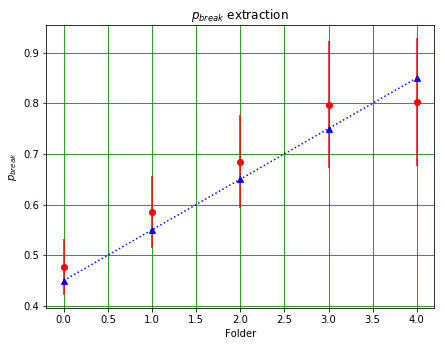

In [17]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
def invAsymm(A, Ae, a, ae, b, be, c, ce, incFuncErr):
    #
    p = a + b*A + c*A**2
    if incFuncErr:
        #
        # Error including uncertainties in coefficients in inverting function
        pe = np.sqrt(((b + 2*A*c)*Ae)**2 + (ae)**2 + (A*be)**2 + (A**2*ce)**2)
    else:
        #
        # Error assuming coefficients in inverting function perfectly known
        pe = np.abs((b + 2*A*c)*Ae)
    #
    return p, pe
#
incFuncErr = True 
#
pB, pBerr = invAsymm(avgALRT, errALRT, aVal, aErr, bVal, bErr, cVal, cErr, incFuncErr)
MCtruth = [0.45, 0.55, 0.65, 0.75, 0.85]
print(" ")
#print(f"Folder\t LR asymmetry\t Error\t pBreak\t Error\t MC truth")
print("Folder\t LR asymmetry\t Error\t pBreak\t Error\t MC truth")
for nd in range(0, num_dirsT):
    #print(f"{nd}\t {avgALRT[nd]:.3f}\t\t {errALRT[nd]:.3f}\t {pB[nd]:.3f}\t {pBerr[nd]:.3f}\t {MCtruth[nd]:.3f}")
    print("{}\t {:.3f}\t {:.3f}\t {:.3f}\t {:.3f}\t {:.3f}".format(nd, avgALRT[nd], errALRT[nd], pB[nd], pBerr[nd], MCtruth[nd]))
#
fig, axs = plt.subplots(1, figsize = (pltX, pltY))
axs.set_title("$p_{break}$ extraction")
axs.errorbar(xPlotT, pB, yerr = pBerr, linestyle = '', color = 'r', marker = 'o')
axs.plot(xPlotT, MCtruth, linestyle = ':', marker = '^', color = 'b')
axs.set_xlabel("Folder")
axs.set_ylabel("$p_{break}$")
axs.grid(color = 'g')
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since notebook start is",str(now - startNB))
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since notebook start is",str(now - startNB))